<a href="https://colab.research.google.com/github/carlaolivei/Hackathon-Motor-Pegabot/blob/main/New-Model-From-INCT-DD-Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Elabora√ß√£o de um novo modelo de classifica√ß√£o com base nas informa√ß√µes de usu√°rios avaliados pelo INCT-DD**

In [62]:
#Carrega as bibliotecas
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, mean_squared_error, r2_score, mean_absolute_percentage_error, max_error, explained_variance_score, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import math
import statistics
import datetime
import pytz
import pickle
## NLTK (biblioteca para processamento de linguagem natural)
import nltk
nltk.download('rslp')
nltk.download('stopwords')
from nltk.stem.rslp import RSLPStemmer ##http://www.nltk.org/howto/portuguese_en.html
from nltk.corpus import stopwords

#O primeiro uso exige obter os pacotes adicionais da biblioteca descomentando as linhas a seguir
#Instala os pacotes de termos do nltk (apenas na primeira vez)
#nltk.download()
#nltk.download('rslp')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**O novo modelo de classifica√ß√£o de bots foi constru√≠do com base nos usu√°rios manualmente avaliados pelo INCT-DD**

Essa escolha foi tomada considerando que esse conjunto de dados √© o melhor que se possui quanto √† real possibilidade de um usu√°rio do Twitter ser um bot, n√£o existindo bases de avalia√ß√£o dentro da realidade brasileira (especialmente quanto ao portugu√™s), bem como atualizadas

In [2]:
#Busca os dados dos usu√°rios avaliados
datafile_users = "/content/sample_data/inct_users.csv"
df_users = pd.read_csv(datafile_users, header = 0)

#Preenche os valores NaN con 0 apenas para avalia√ß√£o geral
df_users = df_users.fillna(0)
print(len(df_users))
#Apresenta o total de usu√°rios avaliados
df_users.head()

1074


Unnamed: 0 error                 created_at default_profile  \
0           0     0  2009-06-30 01:05:51+00:00             1.0   
1           1     0  2019-03-09 11:29:52+00:00            True   
2           2     0  2009-10-20 01:19:19+00:00           False   
3           3     0  2020-05-03 19:06:46+00:00            True   
4           4     0  2021-04-25 20:04:17+00:00            True   

                                         description  followers_count  \
0                                                  0             21.0   
1                                                  0           4192.0   
2  Feliz √© a Na√ß√£o cujo Deus √© o Senhor! #ReageBr...           1341.0   
3                                                  0              2.0   
4                                                  0             10.0   

   friends_count           handle  lang            location  \
0          108.0         lemathes   0.0   Brasil, S√£o Paulo   
1         4886.0  Maurcio98905595   0.0         MG , Brasil   
2         1854.0         LunViana   0.0  Araraquara, Brasil   
3           31.0     felipeleixas   0.0                   0   
4           21.0  JoseCar41451194   0.0                   0   

                                 name  \
0                      Leandro Mathes   
1                       Maur√≠cio Lima   
2                             Luciana   
3                              Felipe   
4  Jose Carlos Marques de Albuquerque   

                                       profile_image    twitter_id  \
0  http://pbs.twimg.com/profile_images/1141547105...  5.225325e+07   
1  http://pbs.twimg.com/profile_images/1104354755...  1.104344e+18   
2  http://pbs.twimg.com/profile_images/1436716357...  8.373752e+07   
3  http://pbs.twimg.com/profile_images/1264366970...  1.257024e+18   
4  http://pbs.twimg.com/profile_images/1429559356...  1.386411e+18   

  twitter_is_protected verified withheld_in_countries  
0                  0.0      0.0                    []  
1                False    False                    []  
2                False    False                    []  
3                False    False                    []  
4                False    False                    []

**No novo modelos s√£o consideradas apenas as informa√ß√µes associadas como "√â bot?" de respotas "Sim" ou "N√£o"**

In [3]:
#Busca a classifica√ß√£o do INCT-DD
datafile_handles = "/content/sample_data/handles_inct.csv" #A classifica√ß√£o √© a mesma da sample1
df_handles = pd.read_csv(datafile_handles, header = 0)
print(len(df_handles))
df_handles['√â Bot?'].head()

1074


0    n√£o
1    n√£o
2    n√£o
3    sim
4    N√£o
Name: √â Bot?, dtype: object

In [4]:
df_handles.head()

Unnamed: 0  Unnamed: 0.1                         tabelaAmostra         p  \
0           0             1         https://twitter.com/@lemathes  0000.csv   
1           1             2  https://twitter.com/@Maurcio98905595  0000.csv   
2           2             3         https://twitter.com/@LunViana  0000.csv   
3           3             4     https://twitter.com/@felipeleixas  0000.csv   
4           4             5  https://twitter.com/@JoseCar41451194  0000.csv   

  √â Bot? Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0    n√£o                                      n√£o se aplica          NaN   
1    n√£o                                      n√£o se aplica          NaN   
2    n√£o                                      n√£o se aplica          NaN   
3    sim                                  Publicar hashtags       Atacar   
4    N√£o                                      n√£o se aplica          NaN   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   
1                      n√£o                                        n√£o   
2                      n√£o                                        n√£o   
3                      sim                                        sim   
4                      n√£o                                        n√£o   

  Parece s√≥ Retweetar? S√≥ compartilha links? S√≥ faz coment√°rios?  \
0                  n√£o                   n√£o                 n√£o   
1                  n√£o                   n√£o                 n√£o   
2                  n√£o                   n√£o                 n√£o   
3                  n√£o                   n√£o                 n√£o   
4                  n√£o                   n√£o                 n√£o   

  Enaltece muito outros usu√°rios? Faz muito uso de emojis?  \
0                             n√£o                      n√£o   
1                             n√£o                      n√£o   
2                             n√£o                      n√£o   
3                             n√£o                      n√£o   
4                             n√£o                      n√£o   

  Tem muitos posts sem textos? Unnamed: 14           handle  
0                          n√£o         NaN         lemathes  
1                          n√£o         NaN  Maurcio98905595  
2                          n√£o         NaN         LunViana  
3                          n√£o         NaN     felipeleixas  
4                          n√£o         NaN  JoseCar41451194

**As mais recentes postagens dos usu√°rios foram consideradas como um atributo do modelo**

Para a classifica√ß√£o dos usu√°rios, o novo modelo inclui atributos relacionados com as postagens dos usu√°rios, na tentativa de extrair informa√ß√£o mais atualizada e din√¢mica de sua atua√ß√£o. Entretanto, os textos das postagens foram utilizados unificando seus conte√∫dos e extraindo informa√ß√µes representativas, tais como os termos mais recorrentemente utilizados, diferen√ßa no tempo das postagens e repostagens

In [5]:
#Recupera os √∫ltimos twittes
datafile_timeline = "/content/sample_data/inct_timelines.csv"
df_timeline = pd.read_csv(datafile_timeline, header = 0)
print(len(df_timeline))
df_timeline.head(1)

82413


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,8,12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Unnamed: 0  error tweet_author  tweet_author_id_str  tweet_contributors  \
0           0    NaN     lemathes             52253248                 NaN   

            tweet_created_at  tweet_favorite_count tweet_favorited tweet_geo  \
0  2022-03-09 02:10:58+00:00                   0.0             0.0       NaN   

  tweet_hashtags      tweet_id         tweet_id_str tweet_is_retweet  \
0             []  1.501380e+18  1501379987747876874              0.0   

  tweet_lang tweet_place tweet_retweeted         tweet_source  \
0         pt         NaN             0.0  Twitter for Android   

                         tweet_text  
0  @LucianoHangBr J√° demorou muito!

Aplica um pr√©-processamento nos dados para unificar a informa√ß√£o da postagens se tratar de um retweet

In [6]:
#identifica os formatos existentes
df_timeline['tweet_is_retweet'].unique()

array(['0.0', 'False', 'True', False, True], dtype=object)

In [7]:
df_timeline['retweet_tratado'] = df_timeline['tweet_is_retweet'].apply(lambda x: "sim" if (x == 'True' or x == True) else "n√£o")
df_timeline['retweet_tratado'].unique()

array(['n√£o', 'sim'], dtype=object)

In [8]:
#Necess√°rio reverificar no texto do tweet por RT @, pois o campo tweet_is_retweet falha em algumas situa√ß√µes n√£o identificadas
#Parecem ser os RT com coment√°rios adicionais
#for tweet in df_timeline['retweet_tratado', 'tweet_text']:
#    if tweet['retweet_tratado'] == 'n√£o':
#        if tweet['tweet_text'].find("RT @") != -1:
#            tweet['retweet_tratado'] = 'sim'
#len(df_timeline)
#for i in range(len(df_timeline)):
#    if df_timeline.iloc[i]['retweet_tratado'] == 'n√£o':
#        if df_timeline.iloc[i]['tweet_text'].find("RT @") != -1:
#            df_timeline.iloc[i]['retweet_tratado']  = 'sim'
df_timeline['tweet_com_rt_tratado'] = df_timeline['tweet_text'].apply(lambda x: "sim" if x.find("RT @") != -1 else "n√£o" )
df_timeline['tweet_com_rt_tratado']

0        n√£o
1        sim
2        n√£o
3        n√£o
4        n√£o
        ... 
82408    sim
82409    sim
82410    sim
82411    sim
82412    n√£o
Name: tweet_com_rt_tratado, Length: 82413, dtype: object

In [9]:
#Combina em uma √∫nica coluna as informa√ß√µes de retweets e tweets com RT comentados
def reune_rt(retweet,rt):
    if retweet == 'sim' or rt == 'sim':
        return 'sim'
    else:
        return 'n√£o'

df_timeline['retweet_e_tweet_com_rt_tratado'] = df_timeline.apply(lambda x: reune_rt(x.retweet_tratado, x.tweet_com_rt_tratado), axis=1)
df_timeline.head(2)

Unnamed: 0  error tweet_author  tweet_author_id_str  tweet_contributors  \
0           0    NaN     lemathes             52253248                 NaN   
1           1    NaN     lemathes             52253248                 NaN   

            tweet_created_at  tweet_favorite_count tweet_favorited tweet_geo  \
0  2022-03-09 02:10:58+00:00                   0.0             0.0       NaN   
1  2022-03-09 02:10:12+00:00                   0.0           False       NaN   

  tweet_hashtags  ...         tweet_id_str  tweet_is_retweet tweet_lang  \
0             []  ...  1501379987747876874               0.0         pt   
1             []  ...  1501379796210757632             False         pt   

  tweet_place tweet_retweeted         tweet_source  \
0         NaN             0.0  Twitter for Android   
1         NaN           False  Twitter for Android   

                                          tweet_text retweet_tratado  \
0                   @LucianoHangBr J√° demorou muito!             n√£o   
1  RT @LucianoHangBr: A vida precisa continuar e ...             n√£o   

  tweet_com_rt_tratado retweet_e_tweet_com_rt_tratado  
0                  n√£o                            n√£o  
1                  sim                            sim  

[2 rows x 21 columns]

In [10]:
df_timeline[df_timeline["retweet_e_tweet_com_rt_tratado"] == 'sim']

Unnamed: 0  error     tweet_author  tweet_author_id_str  \
1               1    NaN         lemathes             52253248   
5               5    NaN         lemathes             52253248   
6               6    NaN         lemathes             52253248   
7               7    NaN         lemathes             52253248   
8               8    NaN         lemathes             52253248   
...           ...    ...              ...                  ...   
82406       82406    NaN  FATIMAC75843178  1349784643244093440   
82408       82408    NaN  FATIMAC75843178  1349784643244093440   
82409       82409    NaN  FATIMAC75843178  1349784643244093440   
82410       82410    NaN  FATIMAC75843178  1349784643244093440   
82411       82411    NaN  FATIMAC75843178  1349784643244093440   

       tweet_contributors           tweet_created_at  tweet_favorite_count  \
1                     NaN  2022-03-09 02:10:12+00:00                   0.0   
5                     NaN  2022-02-27 13:38:14+00:00                   0.0   
6                     NaN  2022-02-18 04:17:53+00:00                   0.0   
7                     NaN  2022-02-18 04:11:31+00:00                   0.0   
8                     NaN  2022-02-18 04:10:00+00:00                   0.0   
...                   ...                        ...                   ...   
82406                 NaN  2022-03-17 12:10:29+00:00                   0.0   
82408                 NaN  2022-03-17 12:09:52+00:00                   0.0   
82409                 NaN  2022-03-17 12:09:18+00:00                   0.0   
82410                 NaN  2022-03-17 12:08:46+00:00                   0.0   
82411                 NaN  2022-03-17 12:08:38+00:00                   0.0   

      tweet_favorited tweet_geo tweet_hashtags  ...         tweet_id_str  \
1               False       NaN             []  ...  1501379796210757632   
5               False       NaN             []  ...  1497929065302482946   
6               False       NaN             []  ...  1494526561902546944   
7               False       NaN             []  ...  1494524957593845762   
8               False       NaN             []  ...  1494524573919940609   
...               ...       ...            ...  ...                  ...   
82406           False       NaN             []  ...  1504429966729138176   
82408           False       NaN             []  ...  1504429810352898052   
82409           False       NaN             []  ...  1504429669613031426   
82410           False       NaN             []  ...  1504429535818924033   
82411           False       NaN             []  ...  1504429502369259522   

       tweet_is_retweet tweet_lang tweet_place tweet_retweeted  \
1                 False         pt         NaN           False   
5                 False         pt         NaN           False   
6                 False         pt         NaN           False   
7                 False         pt         NaN           False   
8                 False         pt         NaN           False   
...                 ...        ...         ...             ...   
82406             False         pt         NaN           False   
82408             False         pt         NaN           False   
82409             False         pt         NaN           False   
82410             False         pt         NaN           False   
82411             False         pt         NaN           False   

              tweet_source                                         tweet_text  \
1      Twitter for Android  RT @LucianoHangBr: A vida precisa continuar e ...   
5      Twitter for Android  RT @roxmo: Puxa, que pena, passou t√£o perto!‚Ä¶ ...   
6      Twitter for Android  RT @mila_sayuri: Algu√©m poderia confirmar se e...   
7      Twitter for Android  RT @RenzoGracieBJJ: Quando postei aqui o v√≠deo...   
8      Twitter for Android        RT @roxmo: Vc confia nas urnas eletr√¥nicas?   
...                    ...                                                ...  

Extrai a diferen√ßa em segundos entre as postagens do usu√°rio

In [11]:
#Incluir uma dedida da distancia temporal entre twittes (mediana e m√≠nimo)
df_handles['Tempo mediano'] = np.array(len(df_handles))
df_handles['Tempo menor']   = np.array(len(df_handles))
iuser = 0
for user in df_handles['handle']:
    df_temp = df_timeline[df_timeline['tweet_author'] == user]
    itweet = 0
    menor = 100000
    difs = list()
    tweet_date_prev = None
    for tweet in df_temp['tweet_created_at']:
        tweet_date = pd.to_datetime(pd.to_datetime(tweet).strftime("%Y-%m-%dT%H:%M:%S.%fZ"))
        if itweet > 0:
            dif = (tweet_date_prev - tweet_date).seconds
            if dif < menor:
                menor = dif
            difs.append(dif)
        else:
            tweet_date_prev = tweet_date
        tweet_date_prev = tweet_date
        itweet += 1
    if len(difs) > 0:
        mediana = statistics.median(difs)
    else:
        mediana = 1000
    print(user + ' - ' + str(menor) + ' - ' + str(mediana)+'\n')
    df_handles['Tempo mediano'][iuser] = mediana
    df_handles['Tempo menor'][iuser]   = menor
    iuser += 1
    
    

lemathes - 16 - 1917

Maurcio98905595 - 1 - 22

LunViana - 2 - 34

felipeleixas - 141 - 40791.0

JoseCar41451194 - 9 - 584

stefmilhori - 0 - 862

Maurio0916 - 11 - 7975

alaincremonezi - 7 - 210

marctrickguedes - 24 - 436

Valdir_25 - 16 - 10217



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


HermesMachadoAP - 26 - 3416

euclaudemir - 4 - 8076

LongoMarlongo - 5 - 117

Tadeu88537223 - 4 - 147

EliasBispodeCe1 - 3 - 63

lessa_tadeu - 100000 - 1000

kentyan71 - 4 - 136

Sirenite1 - 1 - 142

elechimamil - 6 - 423

mhelena17 - 4 - 74

victorcalazans - 15 - 405

AnaPedros2308 - 4 - 136

ricardo_lacava - 24 - 235

AslanDeHogwarts - 10 - 1933

Patriota7M - 0 - 24

luGusmao1 - 2 - 15

GilAndrade5 - 6 - 66

ClaytonSampaio5 - 0 - 20900

filhadefridak - 17 - 14945

lucas_neves164 - 100000 - 1000

Thiago48035185 - 6 - 71

herciconti - 0 - 110

FlaviaPauletti - 13 - 2250

ElielAmorim9 - 14 - 207

Lunar_Vante - 6 - 380

lemosmarl - 3 - 10776

joaocarlosjc - 5 - 1533

georgedebarros - 16 - 314

valterpn - 2 - 290

Mariade25585540 - 5 - 249

NTresolavy - 6 - 193

jonny_1309 - 3 - 27605

Dani_BernMor - 16 - 652

lui45807682 - 2 - 180

OluasSnanaj - 22 - 2964

abreumartha - 7 - 104

deuzemaroliveir - 5 - 49

Tahuamello - 100000 - 1000

BorjaoOp - 100000 - 1000

MelchiranL - 3 - 4607

_mcalhe

**Os dados inicialmente tratados s√£o reunidos com a classifica√ß√£o dada pelo INCT-DD**

In [12]:
#Reune os dados do usu√°rio com a classifica√ß√£o
df_result_merge = pd.merge(df_handles, df_users, on=['handle'])
print(len(df_result_merge))
df_result_merge.head(1)

1072


Unnamed: 0_x  Unnamed: 0.1                  tabelaAmostra         p √â Bot?  \
0             0             1  https://twitter.com/@lemathes  0000.csv    n√£o   

  Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0                                      n√£o se aplica          NaN   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   

  Parece s√≥ Retweetar?  ... followers_count friends_count lang  \
0                  n√£o  ...            21.0         108.0  0.0   

            location            name  \
0  Brasil, S√£o Paulo  Leandro Mathes   

                                       profile_image  twitter_id  \
0  http://pbs.twimg.com/profile_images/1141547105...  52253248.0   

   twitter_is_protected  verified  withheld_in_countries  
0                   0.0       0.0                     []  

[1 rows x 34 columns]

**Os dados das postagens foram reunidos para a extra√ß√£o de informa√ß√µes representativas**

Para viabilizar o treinamento do modelo, os dados por postagens foram convertidos em conjuntos por usu√°rio (autor do tweet, e a representa√ß√£o foi dada por informa√ß√µes sumarizadas ou probabil√≠sticas, por exemplo, as hashtags mais utilizadas ou o percentual de postagens realizadas a partir do Android, iPhone ou Web.

In [13]:
#Reune todos os tweets de um mesmo autor em um √∫nico texto, separando apenas por v√≠rgula
df_result_text = df_timeline.groupby('tweet_author').agg({'tweet_text':lambda col: ', '.join(col)}).reset_index()
print(len(df_result_text))
df_result_text.head()

835


tweet_author                                         tweet_text
0  100_bolsonaro  @OracoesB @wander_fabricio @DinhaCarvalho8 #Bo...
1      13valber1  RT @leandroruschel: Tente encontrar na extrema...
2        1976Mnc  RT @MinEconomia: ‚ÄúN√≥s estamos assistindo a uma...
3    ACamargo241  RT @juliovschneider: Se liga na viatura daqui ...
4      AControld  Carro Pajero TR4 4X4 Automatica, podendo sair ...

In [14]:
#Reune todos as hashtags utilizadas por um mesmo autor em um √∫nico texto, separando apenas por v√≠rgula
df_result_hashtags = df_timeline.groupby('tweet_author').agg({'tweet_hashtags':lambda col: ', '.join(col)}).reset_index()
df_result_hashtags.head()

tweet_author                                     tweet_hashtags
0  100_bolsonaro  ['Bolsonaro2022'], ['MoroTraidor'], [], ['Moro...
1      13valber1  [], [], [], [], [], [], [], [], [], [], [], []...
2        1976Mnc  [], [], [], [], [], [], ['PLP235N√ÉO'], [], ['P...
3    ACamargo241  [], [], [], [], [], [], [], [], [], [], [], []...
4      AControld  ['RedeBBB', 'tbt', 'iphone', 'apple'], ['Natal...

In [ ]:
#Reune a informa√ß√£o de fonte de todos os tweets de um mesmo autor em um √∫nico texto, separando apenas por v√≠rgula
df_result_source = df_timeline.groupby('tweet_author').agg({'tweet_source':lambda col: ', '.join(col)}).reset_index()
df_result_source.head()

tweet_author                                       tweet_source
0  100_bolsonaro  Twitter Web App, Twitter Web App, Twitter Web ...
1      13valber1  Twitter for Android, Twitter for Android, Twit...
2        1976Mnc  Twitter for iPhone, Twitter for iPhone, Twitte...
3    ACamargo241  Twitter for Android, Twitter for Android, Twit...
4      AControld  Twitter Web App, Twitter Web App, Twitter Web ...

In [ ]:
#Reune as informa√ß√µes de twettes que s√£o retweets
df_result_retweet = df_timeline.groupby('tweet_author').agg({'retweet_tratado':lambda col: ', '.join(col)}).reset_index()
df_result_retweet.head()

tweet_author                                    retweet_tratado
0  100_bolsonaro  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...
1      13valber1  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...
2        1976Mnc  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...
3    ACamargo241  n√£o, n√£o, n√£o, n√£o, n√£o, sim, n√£o, n√£o, n√£o, n...
4      AControld  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...

In [ ]:
#Reune as informa√ß√µes de twettes com RT
df_result_tweet_com_rt = df_timeline.groupby('tweet_author').agg({'tweet_com_rt_tratado':lambda col: ', '.join(col)}).reset_index()
df_result_tweet_com_rt.head()

tweet_author                               tweet_com_rt_tratado
0  100_bolsonaro  n√£o, n√£o, sim, n√£o, n√£o, sim, sim, sim, n√£o, n...
1      13valber1  sim, sim, sim, sim, n√£o, n√£o, n√£o, n√£o, n√£o, n...
2        1976Mnc  sim, sim, n√£o, n√£o, sim, sim, n√£o, sim, sim, s...
3    ACamargo241  sim, sim, sim, sim, sim, n√£o, sim, sim, sim, s...
4      AControld  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...

In [ ]:
#Reune as informa√ß√µes da jun√ß√£o de retweets e tweets com rt
df_result_retweet_e_tweet_com_rt = df_timeline.groupby('tweet_author').agg({'retweet_e_tweet_com_rt_tratado':lambda col: ', '.join(col)}).reset_index()
df_result_retweet_e_tweet_com_rt.head()

tweet_author                     retweet_e_tweet_com_rt_tratado
0  100_bolsonaro  n√£o, n√£o, sim, n√£o, n√£o, sim, sim, sim, n√£o, n...
1      13valber1  sim, sim, sim, sim, n√£o, n√£o, n√£o, n√£o, n√£o, n...
2        1976Mnc  sim, sim, n√£o, n√£o, sim, sim, n√£o, sim, sim, s...
3    ACamargo241  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...
4      AControld  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...

In [ ]:
#Reune os dados (merge) do usu√°rios, suas avalia√ß√µes com texto dos tweets, as hashtags, as fontes e os retweets
df_result_merge = pd.merge(df_handles, df_users, on=['handle'])
df_result_merge = pd.merge(df_result_merge,df_result_text, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_hashtags, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_source, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_retweet, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_tweet_com_rt, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_retweet_e_tweet_com_rt, left_on=['handle'], right_on=['tweet_author'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing 'suffixes' which cause duplicate columns {'tweet_author_x'} in the result is deprecated and will raise a MergeError in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing 'suffixes' which cause duplicate columns {'tweet_author_x'} in the result is deprecated and will raise a MergeError in a future version.
  


In [ ]:
#Exibe parte dos resultados da jun√ß√£o (nem todos os usu√°rios ainda est√£o ativos e n√∫mero de amostras diminui)
print(len(df_result_merge))
df_result_merge.head(1)

834


Unnamed: 0_x  Unnamed: 0.1                  tabelaAmostra         p √â Bot?  \
0             0             1  https://twitter.com/@lemathes  0000.csv    n√£o   

  Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0                                      n√£o se aplica          NaN   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   

  Parece s√≥ Retweetar?  ...  tweet_author_y  \
0                  n√£o  ...        lemathes   

                                      tweet_hashtags tweet_author_x  \
0  [], [], [], [], [], [], [], [], [], [], [], []...       lemathes   

                                        tweet_source  tweet_author_y  \
0  Twitter for Android, Twitter for Android, Twit...        lemathes   

                                     retweet_tratado tweet_author_x  \
0  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...       lemathes   

                                tweet_com_rt_tratado  tweet_author_y  \
0  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...        lemathes   

                      retweet_e_tweet_com_rt_tratado  
0  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...  

[1 rows x 46 columns]

**A classifica√ß√£o dos usu√°rios foi padronizada para 0 - N√£o Bot e 1 - Bot**

In [ ]:
#Padroniza a sa√≠da da classifica√ß√£o do INCT-DD para bot e monta o conjunto Y
df = df_result_merge
y = df['√â Bot?'].apply(lambda x: 1 if (x == 'Sim' or x == 'sim') else 0)
y.reset_index(drop=True, inplace=True)
y.head()

0    0
1    0
2    0
3    1
4    0
Name: √â Bot?, dtype: int64

In [ ]:
##Seleciona as colunas para o conjunto X
#feature_cols = ['tweet_text'] #,'tweet_source','tweet_hashtags'
#x = df['tweet_text']
#x.shape

** [Classficando apenas pelo texto dos Twittes (NLTK)] **

In [ ]:
##Prepara o conjunto de dados para treinamento e teste
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) 

In [ ]:
##M√©todo para vetorizar e contabilizar os termos
stemmer = nltk.stem.RSLPStemmer()
class StemmedCountVectorizerRSLPS(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizerRSLPS, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizerRSLPS(stop_words=nltk.corpus.stopwords.words('portuguese'))
tfidf_transformer = TfidfTransformer()

In [ ]:
##Pipeline para extrair as informa√ßoes e classificar com base no texto (pode ser usado ANN ou MNB [MultinomialNB(fit_prior=False)])
#text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
#                      ('tfidf', TfidfTransformer()),
#                      ('mnb', MLPClassifier(random_state=1, max_iter=600, activation='relu',solver='adam')),
#])
#text_mnb_stemmed = text_mnb_stemmed.fit(x_train, y_train)

In [ ]:
#text_mnb_stemmed

In [ ]:
##Avalia a classifica√ß√£o
#predicted_mnb_stemmed = text_mnb_stemmed.predict(x_test)
#np.mean(predicted_mnb_stemmed == y_test)

**Os atributos do treinamentos envolvem diversos fatores**

Uma das etapas mais crit√≠cas da modelagem √© a defini√ß√£o dos atributos que representam o cen√°rio real, nesse sentido foram inclu√≠das o m√°ximo de vari√°veis que pudessem representar um usu√°rio e suas atividades na rede, desde o tamanho do login escolhido at√© o tempo m√≠nimo entre suas postagens. Na sequ√™ncia s√£o realizadas as atividades de extra√ß√£o, tratamento e jun√ß√£o dessas informa√ß√µes como atributos do conjunto de treinamento do modelo.

In [ ]:
df.columns #df √© o conjunto completo de dados, j√° com os twittes-hashtags-sources-retweets em campos √∫nicos

Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'tabelaAmostra', 'p', '√â Bot?',
       'Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria?', 'Fun√ß√£o #2',
       'Comportamento agressivo?',
       'Comportamento repetitivo com # ou men√ß√µes?', 'Parece s√≥ Retweetar?',
       'S√≥ compartilha links?', 'S√≥ faz coment√°rios?',
       'Enaltece muito outros usu√°rios?', 'Faz muito uso de emojis?',
       'Tem muitos posts sem textos?', 'Unnamed: 14', 'handle',
       'Tempo mediano', 'Tempo menor', 'Unnamed: 0_y', 'error', 'created_at',
       'default_profile', 'description', 'followers_count', 'friends_count',
       'lang', 'location', 'name', 'profile_image', 'twitter_id',
       'twitter_is_protected', 'verified', 'withheld_in_countries',
       'tweet_author_x', 'tweet_text', 'tweet_author_y', 'tweet_hashtags',
       'tweet_author_x', 'tweet_source', 'tweet_author_y', 'retweet_tratado',
       'tweet_author_x', 'tweet_com_rt_tratado', 'tweet_author_y',
       'retweet_e_tweet_com_r

In [ ]:
df.head(1)

Unnamed: 0_x  Unnamed: 0.1                  tabelaAmostra         p √â Bot?  \
0             0             1  https://twitter.com/@lemathes  0000.csv    n√£o   

  Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0                                      n√£o se aplica          NaN   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   

  Parece s√≥ Retweetar?  ...  tweet_author_y  \
0                  n√£o  ...        lemathes   

                                      tweet_hashtags tweet_author_x  \
0  [], [], [], [], [], [], [], [], [], [], [], []...       lemathes   

                                        tweet_source  tweet_author_y  \
0  Twitter for Android, Twitter for Android, Twit...        lemathes   

                                     retweet_tratado tweet_author_x  \
0  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...       lemathes   

                                tweet_com_rt_tratado  tweet_author_y  \
0  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...        lemathes   

                      retweet_e_tweet_com_rt_tratado  
0  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...  

[1 rows x 46 columns]

De todo os conjuntos de informa√ß√µes dispon√≠veis n√£o foram selecionados aquelas que n√£o poderiam ser automaticamente extra√≠dos dos perfis e atividades dos usu√°rios na rede. Portanto, as classifica√ß√µes como "comportamento agressivo?", "Parece s√≥ Retweetar?", entre outras, n√£o foram inclu√≠dos no conjunto de treinamento.

In [ ]:
feature_cols = ['followers_count', 'friends_count', 'Tempo mediano', 'Tempo menor']
x = df[feature_cols]

In [ ]:
##Converte os testos em frequ√™ncias
#st = stemmed_count_vect.fit_transform((df['tweet_text']))
#tfidf_transformer = TfidfTransformer()
#x_tfidf = tfidf_transformer.fit_transform(st)
#x_tfidf

In [ ]:
##Inclui as frequ√™ncias no conjunto x
#x_tfidf.shape
#x.join(pd.DataFrame(x_tfidf.todense()))

In [ ]:
len(df['tweet_hashtags'][7].replace("[","").replace("]","").replace(", \'","$").split("$"))
len(df['tweet_hashtags'][7].split(", ["))

100

In [ ]:
#Inclui os quantitativos de hashtages utilizadas (e a mediana por postagem)

qtd_hashtags = df['tweet_hashtags'].apply(lambda x: len(x.replace("[","").replace("]","").replace(", \'","$").split("$")))
x['Quantidade hashtags'] = np.array(list(qtd_hashtags))
qtd_hashtags_media = df['tweet_hashtags'].apply(lambda x: len(x.replace("[","").replace("]","").replace(", \'","$").split("$"))/len(x.split(", [")))
x['Quantidade hashtags media'] = np.array(list(qtd_hashtags_media))

x.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


followers_count  friends_count  Tempo mediano  Tempo menor  \
0             21.0          108.0           1917           16   
1           4192.0         4886.0             22            1   
2           1341.0         1854.0             34            2   
3              2.0           31.0          40791          141   
4             10.0           21.0            584            9   

   Quantidade hashtags  Quantidade hashtags media  
0                   13                   0.130000  
1                    2                   0.020000  
2                    6                   0.060000  
3                   20                   0.425532  
4                   10                   0.100000

In [ ]:
#Inclui o n√∫mero de d√≠gitos no nome
username_digitos = df['handle'].apply(lambda x: sum(c.isdigit() for c in str(x)) ) 
x['Digitos no username'] = np.array(list(username_digitos))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#O tamanho do nome e do login
tam_username = df['handle'].apply(lambda x: len(str(x)))
tam_nome = df['name'].apply(lambda x: len(str(x)))
x['Tamanho do username'] = np.array(list(tam_username))
x['Tamanho do nome'] = np.array(list(tam_nome))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
x.head()

followers_count  friends_count  Tempo mediano  Tempo menor  \
0             21.0          108.0           1917           16   
1           4192.0         4886.0             22            1   
2           1341.0         1854.0             34            2   
3              2.0           31.0          40791          141   
4             10.0           21.0            584            9   

   Quantidade hashtags  Quantidade hashtags media  Digitos no username  \
0                   13                   0.130000                    0   
1                    2                   0.020000                    8   
2                    6                   0.060000                    0   
3                   20                   0.425532                    0   
4                   10                   0.100000                    8   

   Tamanho do username  Tamanho do nome  
0                    8               14  
1                   15               13  
2                    8                7  
3                   12                6  
4                   15               34

A fonte do tweet foi considera importante informa√ß√£o, considerando que automa√ß√µes de postagens possam ser facilitadas a partir da vers√£o Web ou que possa existir algum padr√£o no uso das diferentes fontes. Sendo assim, forneceu-se ao m√©todos a informa√ß√£o percentual da origem das postagens do mesmo usu√°rio, seja Android, iPhone ou Web.

In [ ]:
#Calcula a quantidade de twittes por fontes
fonte_android = df['tweet_source'].apply(lambda x: str(x).count('Twitter for Android') )
fonte_iphone = df['tweet_source'].apply(lambda x: str(x).count('Twitter for iPhone') )
fonte_web = df['tweet_source'].apply(lambda x: str(x).count('Twitter Web App') )

In [ ]:
fonte_soma = fonte_android + fonte_iphone + fonte_web
fonte_soma = fonte_soma.apply(lambda x: 1 if x <= 0 else x )

In [ ]:
#Calcula o percentual por usu√°rio
fonte_android = fonte_android/fonte_soma
fonte_iphone = fonte_iphone/fonte_soma
fonte_web = fonte_web/fonte_soma

In [ ]:
x['Fonte de Android'] = np.array(list(fonte_android))
x['Fonte de iPhone'] = np.array(list(fonte_iphone))
x['Fonte de Web'] = np.array(list(fonte_web))
x = x.fillna(0)
x.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

followers_count  friends_count  Tempo mediano  Tempo menor  \
0             21.0          108.0           1917           16   
1           4192.0         4886.0             22            1   
2           1341.0         1854.0             34            2   
3              2.0           31.0          40791          141   
4             10.0           21.0            584            9   

   Quantidade hashtags  Quantidade hashtags media  Digitos no username  \
0                   13                   0.130000                    0   
1                    2                   0.020000                    8   
2                    6                   0.060000                    0   
3                   20                   0.425532                    0   
4                   10                   0.100000                    8   

   Tamanho do username  Tamanho do nome  Fonte de Android  Fonte de iPhone  \
0                    8               14              1.00             0.00   
1                   15               13              0.24             0.00   
2                    8                7              0.18             0.82   
3                   12                6              1.00             0.00   
4                   15               34              0.00             1.00   

   Fonte de Web  
0          0.00  
1          0.76  
2          0.00  
3          0.00  
4          0.00

In [ ]:
#Avalia√ß√£o geral das diferentes fontes
x['Fonte de Android'].describe()

count    834.000000
mean       0.641682
std        0.463189
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Fonte de Android, dtype: float64

In [ ]:
x['Fonte de iPhone'].describe()

count    834.000000
mean       0.198877
std        0.393385
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Fonte de iPhone, dtype: float64

In [ ]:
x['Fonte de Web'].describe()

count    834.000000
mean       0.149848
std        0.330788
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Fonte de Web, dtype: float64

In [ ]:
#Inclui a informa√ß√£o do retweet
df['retweet_tratado'].head()

0    n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...
1    sim, sim, n√£o, sim, sim, sim, sim, n√£o, sim, s...
2    n√£o, n√£o, n√£o, n√£o, sim, n√£o, n√£o, n√£o, n√£o, n...
3    n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...
4    n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...
Name: retweet_tratado, dtype: object

In [ ]:
retweet_tratado = df['retweet_tratado'].apply(lambda x: str(x).count('sim')/len(x.split(",")))
x['retweet_tratado_media'] = np.array(list(retweet_tratado))

In [ ]:
tweet_com_rt = df['tweet_com_rt_tratado'].apply(lambda x: str(x).count('sim')/len(x.split(",")))
x['tweet_com_rt_tratado_media'] = np.array(list(tweet_com_rt))

In [ ]:
retweet_e_tweet_com_rt = df['retweet_e_tweet_com_rt_tratado'].apply(lambda x: str(x).count('sim')/len(x.split(",")))
x['retweet_e_tweet_com_rt_tratado_media'] = np.array(list(retweet_e_tweet_com_rt))

In [ ]:
x_novo = x

In [ ]:
##Inclui os textos dos twittes (NLTK)
#st = stemmed_count_vect.fit_transform((df['tweet_text']))
#tfidf_transformer = TfidfTransformer()
#x_tfidf = tfidf_transformer.fit_transform(st)
#x_tfidf
#x_novo = x.join(pd.DataFrame(x_tfidf.todense()))

In [ ]:
x_novo.shape

(834, 15)

In [ ]:
x_novo.head()

followers_count  friends_count  Tempo mediano  Tempo menor  \
0             21.0          108.0           1917           16   
1           4192.0         4886.0             22            1   
2           1341.0         1854.0             34            2   
3              2.0           31.0          40791          141   
4             10.0           21.0            584            9   

   Quantidade hashtags  Quantidade hashtags media  Digitos no username  \
0                   13                   0.130000                    0   
1                    2                   0.020000                    8   
2                    6                   0.060000                    0   
3                   20                   0.425532                    0   
4                   10                   0.100000                    8   

   Tamanho do username  Tamanho do nome  Fonte de Android  Fonte de iPhone  \
0                    8               14              1.00             0.00   
1                   15               13              0.24             0.00   
2                    8                7              0.18             0.82   
3                   12                6              1.00             0.00   
4                   15               34              0.00             1.00   

   Fonte de Web  retweet_tratado_media  tweet_com_rt_tratado_media  \
0          0.00                   0.10                    0.750000   
1          0.76                   0.54                    0.520000   
2          0.00                   0.08                    0.840000   
3          0.00                   0.00                    0.042553   
4          0.00                   0.00                    0.940000   

   retweet_e_tweet_com_rt_tratado_media  
0                              0.840000  
1                              0.970000  
2                              0.910000  
3                              0.042553  
4                              0.940000

**Com o primeiro conjunto de atributos formado √© poss√≠vel separar o conjunto de dados em treinamento e teste para a elabora√ß√£o do modelo**

In [ ]:
#Cria um modelo de classifica√ß√£o para o conjunto completo
x_train, x_test, y_train, y_test = train_test_split(x_novo, y, test_size=0.3, random_state=1) 

In [ ]:
classifier = RandomForestClassifier(n_jobs=3, random_state=1, n_estimators=100)
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
np.mean(y_pred == y_test)

0.7330677290836654

In [ ]:
##Seleciona os atributos mais "importantes"
#x_new = SelectKBest(chi2, k=20).fit_transform(x_novo, y)

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=1) 

In [ ]:
classifier = RandomForestClassifier(n_jobs=3, random_state=1, n_estimators=100)
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
mean = np.mean(y_pred == y_test)
balanced = balanced_accuracy_score(y_test, y_pred)
print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))
confusion_matrix(y_test, y_pred)

Mean: 0.7330677290836654 | Balanced accuracy: 0.6958582834331337


array([[ 49,  35],
       [ 32, 135]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59        84
           1       0.79      0.81      0.80       167

    accuracy                           0.73       251
   macro avg       0.70      0.70      0.70       251
weighted avg       0.73      0.73      0.73       251



In [ ]:
#Classifica√ß√£o com RNA
classifier = MLPClassifier(max_iter=1200, random_state=1, activation='tanh', solver='adam') #activation: logistic, relu, tanh, identity | solver: lbfgs, sgd, adam
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
mean = np.mean(y_pred == y_test)
balanced = balanced_accuracy_score(y_test, y_pred)
print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))

Mean: 0.7250996015936255 | Balanced accuracy: 0.6691616766467066


**Informa√ß√µes de trend topics**

Outra informa√ß√£o que se mostrou de relev√¢ncia ao longo do trabalho de modelagem foi a rela√ß√£o das postagens de bots com as men√ß√µes e hashtags listadas nos mais atuais 'trend topics', ou seja, o aparente uso de termos altamente utilizados no momento para possivelmente alavancar a visibilidade da postagem.

Para averiguar essa possibilidade, um sistema de monitoramento dos t√≥picos mais mencionados foi criado e cada postagem coletada do usu√°rio foi confrontado com os 'trend topics' do per√≠odo mais pr√≥ximo. Esse confrontamento gerou um percentual de uso desses t√≥picos nas postagens dos usu√°rios.

In [ ]:
#Busca os dados de todas as trending topics recuperadas
datafile_trends = "/content/sample_data/trends_dataclips_qijpjdyxutqsnrteglrjtwjhdjja.csv"
df_trends = pd.read_csv(datafile_trends, header = 0)
#Preenche os valores NaN con 0 apenas para avalia√ß√£o geral
df_trends = df_trends.fillna(0)
print(len(df_trends))
df_trends.head()

2680


trending_id             trend_date_time                   trend   user1_id  \
0            1  2021-12-03 21:03:31.034742       #HappyBirthdayJin          0   
1            2  2021-12-03 21:03:31.286371                    suga   28431722   
2            3  2021-12-03 21:03:31.417346                 #JINDAY  132699857   
3            4  2021-12-03 21:03:31.527791           #playplusmudo          0   
4            5  2021-12-03 21:03:31.720859  TE AMAMOS DAYANE MELLO   34590687   

                                              tweet1  user2_id  \
0                                                  -         0   
1  Come√ßou!\n\nEles est√£o todos de terno e sentad...  28431722   
2  REIZINHO! Jin, membro do BTS, est√° completando...         0   
3                                                  -         0   
4  TE AMAMOS DAYANE MELLO ‚ù§Ô∏èüç∑ https://t.co/RcyA8R...         0   

                                              tweet2  user3_id  \
0                                                  -         0   
1  Como est√£o se sentindo com a nova indica√ß√£o ao...  28431722   
2                                                  -         0   
3                                                  -         0   
4                                                  -         0   

                                              tweet3  user4_id  \
0                                                  -         0   
1  Voc√™s se preocupam com o futuro agora que j√° r...  78148969   
2                                                  -         0   
3                                                  -         0   
4                                                  -         0   

                                              tweet4  user5_id tweet5  
0                                                  -         0      -  
1  OH L√©o Dias eu vou mandar a fatura pra voc√™, d...         0      -  
2                                                  -         0      -  
3                                                  -         0      -  
4                                                  -         0      -

Entre os passos de tratamentos dos dados das "trend topics" est√° o ajuste dos padr√µes de data e hora dos registros, tanto dos t√≥picos monitorados quanto dos pr√≥prios tweets.
A seguir s√£o extra√≠das as datas dos tweets no formato yyyy-mm-dd, dentro da convers√£o nos pr√≥ximos trechos foi tamb√©m necess√°rio ajustar o "timezone" desses dados.

In [ ]:
#Inclui um percentual de trending topics utilizado por tweet
#Para tweet, busca pelos trending topics imediatamente anteriores
df_timeline['Numero de trendings'] = np.array(len(df_timeline))
df_timeline['Numero de trendings'] = 0
df_trends['Trend Date Time Convertido'] = np.array(len(df_trends))

itrend = 0
for x in df_trends['trend_date_time']:
    df_trends['Trend Date Time Convertido'][itrend] = pd.to_datetime(x).strftime("%Y-%m-%d")
    itrend += 1

df_trends.head()   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


trending_id             trend_date_time                   trend   user1_id  \
0            1  2021-12-03 21:03:31.034742       #HappyBirthdayJin          0   
1            2  2021-12-03 21:03:31.286371                    suga   28431722   
2            3  2021-12-03 21:03:31.417346                 #JINDAY  132699857   
3            4  2021-12-03 21:03:31.527791           #playplusmudo          0   
4            5  2021-12-03 21:03:31.720859  TE AMAMOS DAYANE MELLO   34590687   

                                              tweet1  user2_id  \
0                                                  -         0   
1  Come√ßou!\n\nEles est√£o todos de terno e sentad...  28431722   
2  REIZINHO! Jin, membro do BTS, est√° completando...         0   
3                                                  -         0   
4  TE AMAMOS DAYANE MELLO ‚ù§Ô∏èüç∑ https://t.co/RcyA8R...         0   

                                              tweet2  user3_id  \
0                                                  -         0   
1  Como est√£o se sentindo com a nova indica√ß√£o ao...  28431722   
2                                                  -         0   
3                                                  -         0   
4                                                  -         0   

                                              tweet3  user4_id  \
0                                                  -         0   
1  Voc√™s se preocupam com o futuro agora que j√° r...  78148969   
2                                                  -         0   
3                                                  -         0   
4                                                  -         0   

                                              tweet4  user5_id tweet5  \
0                                                  -         0      -   
1  OH L√©o Dias eu vou mandar a fatura pra voc√™, d...         0      -   
2                                                  -         0      -   
3                                                  -         0      -   
4                                                  -         0      -   

  Trend Date Time Convertido  
0                 2021-12-03  
1                 2021-12-03  
2                 2021-12-03  
3                 2021-12-03  
4                 2021-12-03

O relacionamento dos trends e dos tweets foi realizado percorrendo todos os trends armazenados para cada tweet em data anterior ao do tweet e, para cada trend nessa condi√ß√£o, verificou-se no texto do tweet a presen√ßa de trendings. Caso esteja presente acumulou-se essa ocorr√™ncia, finalizando com a ocorr√™ncia de uso de uma trend por cada tweet.
Este trecho demanda de melhorias em desempenho e na inclus√£o de restri√ß√µes que reduzam o tempo de ocorr√™ncia da trend para mais pr√≥ximo do tweet.

In [ ]:
itweet = 0
for tweet in df_timeline['tweet_created_at']:
    tweet_date = pd.to_datetime(pd.to_datetime(tweet).strftime("%Y-%m-%dT%H:%M:%S.%fZ"))
    df_temp = df_trends[df_trends['Trend Date Time Convertido'] == tweet_date.strftime("%Y-%m-%d")] 
        
    itrend = 0
    for trend in df_temp['Trend Date Time Convertido']:
        trend_date = pd.to_datetime(pd.to_datetime(trend).strftime("%Y-%m-%d"))
        if trend_date <= tweet_date.tz_convert(None):
            if df_timeline['tweet_text'][itweet].find(df_trends['trend'][itrend]) != -1: 
                df_timeline['Numero de trendings'][itweet] = df_timeline['Numero de trendings'][itweet] + 1
        itrend += 1
    print(itweet)    
    itweet += 1     

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


A sa√≠da de streaming foi truncada nas √∫ltimas 5000 linhas.
77413
77414
77415
77416
77417
77418
77419
77420
77421
77422
77423
77424
77425
77426
77427
77428
77429
77430
77431
77432
77433
77434
77435
77436
77437
77438
77439
77440
77441
77442
77443
77444
77445
77446
77447
77448
77449
77450
77451
77452
77453
77454
77455
77456
77457
77458
77459
77460
77461
77462
77463
77464
77465
77466
77467
77468
77469
77470
77471
77472
77473
77474
77475
77476
77477
77478
77479
77480
77481
77482
77483
77484
77485
77486
77487
77488
77489
77490
77491
77492
77493
77494
77495
77496
77497
77498
77499
77500
77501
77502
77503
77504
77505
77506
77507
77508
77509
77510
77511
77512
77513
77514
77515
77516
77517
77518
77519
77520
77521
77522
77523
77524
77525
77526
77527
77528
77529
77530
77531
77532
77533
77534
77535
77536
77537
77538
77539
77540
77541
77542
77543
77544
77545
77546
77547
77548
77549
77550
77551
77552
77553
77554
77555
77556
77557
77558
77559
77560
77561
77562
77563
77564
77565
77566
77567
77568
775

Para cada tweet foi armazenados o n√∫mero de trend topics encontrado.

In [ ]:
df_timeline[df_timeline['Numero de trendings'] > 0].describe()
df_timeline['Numero de trendings'].describe()

count    82413.000000
mean         0.001262
std          0.036843
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: Numero de trendings, dtype: float64

In [ ]:
df_timeline.head(3)
df_timeline.shape

(82413, 22)

As quantidades de trendings utilizadas em cada tweet foram agrupados por autor (usu√°rio), assim foram inclu√≠dos na base de treinamento o n√∫mero de trendings utilizadas, a m√©dia de trendings por tweet desse autor e o n√∫mero m√°ximo de trendings usado em um mesmo tweet.

In [ ]:
#Reune as informa√ß√µes de trends nos tweets por author
df_result_trend = df_timeline.groupby('tweet_author').agg({'Numero de trendings':lambda col: sum(col)/len(col)}).reset_index()
df_result_trend_max = df_timeline.groupby('tweet_author').agg({'Numero de trendings':lambda col: max(col)}).reset_index()
df_result_trend['trends_media'] = df_result_trend['Numero de trendings']
df_result_trend_max['trends_max'] = df_result_trend_max['Numero de trendings']
df_result_trend_max

tweet_author  Numero de trendings  trends_max
0     100_bolsonaro                    0           0
1         13valber1                    0           0
2           1976Mnc                    0           0
3       ACamargo241                    0           0
4         AControld                    3           3
..              ...                  ...         ...
830    wolfjorge201                    0           0
831   yoshio_carlos                    0           0
832    zemariasccp1                    0           0
833          zeplu1                    0           0
834  zfabrogmailcom                    0           0

[835 rows x 3 columns]

In [ ]:
df_handles.head()

Unnamed: 0  Unnamed: 0.1                         tabelaAmostra         p  \
0           0             1         https://twitter.com/@lemathes  0000.csv   
1           1             2  https://twitter.com/@Maurcio98905595  0000.csv   
2           2             3         https://twitter.com/@LunViana  0000.csv   
3           3             4     https://twitter.com/@felipeleixas  0000.csv   
4           4             5  https://twitter.com/@JoseCar41451194  0000.csv   

  √â Bot? Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0    n√£o                                      n√£o se aplica          NaN   
1    n√£o                                      n√£o se aplica          NaN   
2    n√£o                                      n√£o se aplica          NaN   
3    sim                                  Publicar hashtags       Atacar   
4    N√£o                                      n√£o se aplica          NaN   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   
1                      n√£o                                        n√£o   
2                      n√£o                                        n√£o   
3                      sim                                        sim   
4                      n√£o                                        n√£o   

  Parece s√≥ Retweetar? S√≥ compartilha links? S√≥ faz coment√°rios?  \
0                  n√£o                   n√£o                 n√£o   
1                  n√£o                   n√£o                 n√£o   
2                  n√£o                   n√£o                 n√£o   
3                  n√£o                   n√£o                 n√£o   
4                  n√£o                   n√£o                 n√£o   

  Enaltece muito outros usu√°rios? Faz muito uso de emojis?  \
0                             n√£o                      n√£o   
1                             n√£o                      n√£o   
2                             n√£o                      n√£o   
3                             n√£o                      n√£o   
4                             n√£o                      n√£o   

  Tem muitos posts sem textos? Unnamed: 14           handle  Tempo mediano  \
0                          n√£o         NaN         lemathes           1917   
1                          n√£o         NaN  Maurcio98905595             22   
2                          n√£o         NaN         LunViana             34   
3                          n√£o         NaN     felipeleixas          40791   
4                          n√£o         NaN  JoseCar41451194            584   

   Tempo menor  
0           16  
1            1  
2            2  
3          141  
4            9

In [ ]:
df_trends.head()

trending_id             trend_date_time                   trend   user1_id  \
0            1  2021-12-03 21:03:31.034742       #HappyBirthdayJin          0   
1            2  2021-12-03 21:03:31.286371                    suga   28431722   
2            3  2021-12-03 21:03:31.417346                 #JINDAY  132699857   
3            4  2021-12-03 21:03:31.527791           #playplusmudo          0   
4            5  2021-12-03 21:03:31.720859  TE AMAMOS DAYANE MELLO   34590687   

                                              tweet1  user2_id  \
0                                                  -         0   
1  Come√ßou!\n\nEles est√£o todos de terno e sentad...  28431722   
2  REIZINHO! Jin, membro do BTS, est√° completando...         0   
3                                                  -         0   
4  TE AMAMOS DAYANE MELLO ‚ù§Ô∏èüç∑ https://t.co/RcyA8R...         0   

                                              tweet2  user3_id  \
0                                                  -         0   
1  Como est√£o se sentindo com a nova indica√ß√£o ao...  28431722   
2                                                  -         0   
3                                                  -         0   
4                                                  -         0   

                                              tweet3  user4_id  \
0                                                  -         0   
1  Voc√™s se preocupam com o futuro agora que j√° r...  78148969   
2                                                  -         0   
3                                                  -         0   
4                                                  -         0   

                                              tweet4  user5_id tweet5  \
0                                                  -         0      -   
1  OH L√©o Dias eu vou mandar a fatura pra voc√™, d...         0      -   
2                                                  -         0      -   
3                                                  -         0      -   
4                                                  -         0      -   

  Trend Date Time Convertido  
0                 2021-12-03  
1                 2021-12-03  
2                 2021-12-03  
3                 2021-12-03  
4                 2021-12-03

In [ ]:
trends_unique = df_trends.trend.unique()

In [ ]:
df_result_merge.head()

Unnamed: 0_x  Unnamed: 0.1                         tabelaAmostra         p  \
0             0             1         https://twitter.com/@lemathes  0000.csv   
1             1             2  https://twitter.com/@Maurcio98905595  0000.csv   
2             2             3         https://twitter.com/@LunViana  0000.csv   
3             3             4     https://twitter.com/@felipeleixas  0000.csv   
4             4             5  https://twitter.com/@JoseCar41451194  0000.csv   

  √â Bot? Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0    n√£o                                      n√£o se aplica          NaN   
1    n√£o                                      n√£o se aplica          NaN   
2    n√£o                                      n√£o se aplica          NaN   
3    sim                                  Publicar hashtags       Atacar   
4    N√£o                                      n√£o se aplica          NaN   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   
1                      n√£o                                        n√£o   
2                      n√£o                                        n√£o   
3                      sim                                        sim   
4                      n√£o                                        n√£o   

  Parece s√≥ Retweetar?  ...   tweet_author_y  \
0                  n√£o  ...         lemathes   
1                  n√£o  ...  Maurcio98905595   
2                  n√£o  ...         LunViana   
3                  n√£o  ...     felipeleixas   
4                  n√£o  ...  JoseCar41451194   

                                      tweet_hashtags   tweet_author_x  \
0  [], [], [], [], [], [], [], [], [], [], [], []...         lemathes   
1  [], [], [], [], [], [], [], [], [], [], [], []...  Maurcio98905595   
2  [], [], [], [], [], [], [], [], [], [], [], []...         LunViana   
3  [], ['EuApoioVotoImpresso'], [], ['GloboLixo']...     felipeleixas   
4  [], [], [], [], [], [], [], [], [], [], ['OsPi...  JoseCar41451194   

                                        tweet_source   tweet_author_y  \
0  Twitter for Android, Twitter for Android, Twit...         lemathes   
1  Twitter for Android, Twitter Web App, Twitter ...  Maurcio98905595   
2  Twitter for iPhone, Twitter for Android, Twitt...         LunViana   
3  Twitter for Android, Twitter for Android, Twit...     felipeleixas   
4  Twitter for iPhone, Twitter for iPhone, Twitte...  JoseCar41451194   

                                     retweet_tratado   tweet_author_x  \
0  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...         lemathes   
1  sim, sim, n√£o, sim, sim, sim, sim, n√£o, sim, s...  Maurcio98905595   
2  n√£o, n√£o, n√£o, n√£o, sim, n√£o, n√£o, n√£o, n√£o, n...         LunViana   
3  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...     felipeleixas   
4  n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n√£o, n...  JoseCar41451194   

                                tweet_com_rt_tratado   tweet_author_y  \
0  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...         lemathes   
1  n√£o, n√£o, sim, n√£o, n√£o, sim, n√£o, sim, n√£o, n...  Maurcio98905595   
2  sim, sim, sim, sim, n√£o, sim, sim, sim, sim, s...         LunViana   
3  n√£o, n√£o, n√£o, n√£o, sim, n√£o, n√£o, n√£o, n√£o, n...     felipeleixas   
4  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...  JoseCar41451194   

                      retweet_e_tweet_com_rt_tratado  
0  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...  
1  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...  
2  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...  
3  n√£o, n√£o, n√£o, n√£o, sim, n√£o, n√£o, n√£o, n√£o, n...  
4  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...  

[5 rows x 46 columns]

Os valores referentes aos trendings do usu√°rio s√£o reunidos ("merged") com os dados gerais do usu√°rio

In [ ]:
df_result_merge = pd.merge(df_result_merge,df_result_trend, left_on=['handle'], right_on=['tweet_author'])
df_result_merge = pd.merge(df_result_merge,df_result_trend_max, left_on=['handle'], right_on=['tweet_author'])
df_result_merge

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'tweet_author_x'} in the result is deprecated and will raise a MergeError in a future version.
  


Unnamed: 0_x  Unnamed: 0.1                         tabelaAmostra  \
0               0             1         https://twitter.com/@lemathes   
1               1             2  https://twitter.com/@Maurcio98905595   
2               2             3         https://twitter.com/@LunViana   
3               3             4     https://twitter.com/@felipeleixas   
4               4             5  https://twitter.com/@JoseCar41451194   
..            ...           ...                                   ...   
829          1066          1067  https://twitter.com/@CesarNi85939384   
830          1068          1069  https://twitter.com/@PauloRo49195361   
831          1070          1071   https://twitter.com/@Marina92011959   
832          1071          1072  https://twitter.com/@Marcos_28_11_66   
833          1073          1074  https://twitter.com/@FATIMAC75843178   

            p √â Bot? Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria?  \
0    0000.csv    n√£o                                      n√£o se aplica      
1    0000.csv    n√£o                                      n√£o se aplica      
2    0000.csv    n√£o                                      n√£o se aplica      
3    0000.csv    sim                                  Publicar hashtags      
4    0000.csv    N√£o                                      n√£o se aplica      
..        ...    ...                                                ...      
829  1111.csv    Sim                                          Retweetar      
830  1111.csv    Sim                                          Retweetar      
831  1111.csv    Sim                                          Retweetar      
832  1111.csv    Sim                                          Retweetar      
833  1111.csv    Sim                                          Retweetar      

    Fun√ß√£o #2 Comportamento agressivo?  \
0         NaN                      n√£o   
1         NaN                      n√£o   
2         NaN                      n√£o   
3      Atacar                      sim   
4         NaN                      n√£o   
..        ...                      ...   
829       NaN                      n√£o   
830       NaN                      n√£o   
831       NaN                      n√£o   
832       NaN                      n√£o   
833       NaN                      n√£o   

    Comportamento repetitivo com # ou men√ß√µes? Parece s√≥ Retweetar?  ...  \
0                                          n√£o                  n√£o  ...   
1                                          n√£o                  n√£o  ...   
2                                          n√£o                  n√£o  ...   
3                                          sim                  n√£o  ...   
4                                          n√£o                  n√£o  ...   
..                                         ...                  ...  ...   
829                                        sim                  sim  ...   
830                                        sim                  sim  ...   
831                                        n√£o                  sim  ...   
832                                        n√£o                  n√£o  ...   
833                                        sim                  sim  ...   

      tweet_author_x                               tweet_com_rt_tratado  \
0           lemathes  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...   
1    Maurcio98905595  n√£o, n√£o, sim, n√£o, n√£o, sim, n√£o, sim, n√£o, n...   
2           LunViana  sim, sim, sim, sim, n√£o, sim, sim, sim, sim, s...   
3       felipeleixas  n√£o, n√£o, n√£o, n√£o, sim, n√£o, n√£o, n√£o, n√£o, n...   
4    JoseCar41451194  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...   
..               ...                                                ...   
829  CesarNi85939384  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...   
830  PauloRo49195361  n√£o, sim, sim, sim, n√£o, sim, sim, sim, sim, s...   
831   Marina92011959  n√£o, n√£o, n√£o,

In [ ]:
#df_result_merge_trend = df_result_merge
df_result_merge['qtdtrends'] = np.array(list(tam_username))

ttemp = 0
iuser = 0
for user in df_result_merge.tweet_text:
    for trend in trends_unique:
        if user.find(trend) != -1:
            ttemp = ttemp + 1
    print(str(ttemp) + " - " + str(iuser) + " | " + str((iuser/len(df_result_merge.tweet_text))*100) + "%")
    df_result_merge['qtdtrends'][iuser] = ttemp
    iuser = iuser + 1
    ttemp = 0

20 - 0 | 0.0%
12 - 1 | 0.1199040767386091%
29 - 2 | 0.2398081534772182%
9 - 3 | 0.3597122302158274%
29 - 4 | 0.4796163069544364%
23 - 5 | 0.5995203836930456%
2 - 6 | 0.7194244604316548%
21 - 7 | 0.8393285371702638%
12 - 8 | 0.9592326139088728%
19 - 9 | 1.079136690647482%
17 - 10 | 1.1990407673860912%
44 - 11 | 1.3189448441247003%
22 - 12 | 1.4388489208633095%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


7 - 13 | 1.5587529976019185%
26 - 14 | 1.6786570743405276%
22 - 15 | 1.7985611510791366%
29 - 16 | 1.9184652278177456%
17 - 17 | 2.038369304556355%
19 - 18 | 2.158273381294964%
16 - 19 | 2.278177458033573%
30 - 20 | 2.3980815347721824%
0 - 21 | 2.5179856115107913%
4 - 22 | 2.6378896882494005%
26 - 23 | 2.7577937649880093%
16 - 24 | 2.877697841726619%
24 - 25 | 2.997601918465228%
10 - 26 | 3.117505995203837%
7 - 27 | 3.237410071942446%
34 - 28 | 3.357314148681055%
11 - 29 | 3.477218225419664%
11 - 30 | 3.597122302158273%
15 - 31 | 3.7170263788968825%
3 - 32 | 3.8369304556354913%
35 - 33 | 3.9568345323741005%
18 - 34 | 4.07673860911271%
6 - 35 | 4.1966426858513195%
17 - 36 | 4.316546762589928%
18 - 37 | 4.436450839328537%
24 - 38 | 4.556354916067146%
15 - 39 | 4.676258992805756%
22 - 40 | 4.796163069544365%
19 - 41 | 4.916067146282973%
18 - 42 | 5.0359712230215825%
26 - 43 | 5.155875299760192%
17 - 44 | 5.275779376498801%
23 - 45 | 5.39568345323741%
27 - 46 | 5.515587529976019%
15 - 47 |

In [ ]:
df_result_merge.head()

Unnamed: 0_x  Unnamed: 0.1                         tabelaAmostra         p  \
0             0             1         https://twitter.com/@lemathes  0000.csv   
1             1             2  https://twitter.com/@Maurcio98905595  0000.csv   
2             2             3         https://twitter.com/@LunViana  0000.csv   
3             3             4     https://twitter.com/@felipeleixas  0000.csv   
4             4             5  https://twitter.com/@JoseCar41451194  0000.csv   

  √â Bot? Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0    n√£o                                      n√£o se aplica          NaN   
1    n√£o                                      n√£o se aplica          NaN   
2    n√£o                                      n√£o se aplica          NaN   
3    sim                                  Publicar hashtags       Atacar   
4    N√£o                                      n√£o se aplica          NaN   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   
1                      n√£o                                        n√£o   
2                      n√£o                                        n√£o   
3                      sim                                        sim   
4                      n√£o                                        n√£o   

  Parece s√≥ Retweetar?  ...  \
0                  n√£o  ...   
1                  n√£o  ...   
2                  n√£o  ...   
3                  n√£o  ...   
4                  n√£o  ...   

                                tweet_com_rt_tratado   tweet_author_y  \
0  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...         lemathes   
1  n√£o, n√£o, sim, n√£o, n√£o, sim, n√£o, sim, n√£o, n...  Maurcio98905595   
2  sim, sim, sim, sim, n√£o, sim, sim, sim, sim, s...         LunViana   
3  n√£o, n√£o, n√£o, n√£o, sim, n√£o, n√£o, n√£o, n√£o, n...     felipeleixas   
4  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...  JoseCar41451194   

                      retweet_e_tweet_com_rt_tratado   tweet_author_x  \
0  n√£o, sim, n√£o, n√£o, n√£o, sim, sim, sim, sim, s...         lemathes   
1  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...  Maurcio98905595   
2  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...         LunViana   
3  n√£o, n√£o, n√£o, n√£o, sim, n√£o, n√£o, n√£o, n√£o, n...     felipeleixas   
4  sim, sim, sim, sim, sim, sim, sim, sim, sim, s...  JoseCar41451194   

  Numero de trendings_x trends_media   tweet_author_y  Numero de trendings_y  \
0                  0.00         0.00         lemathes                      0   
1                  0.00         0.00  Maurcio98905595                      0   
2                  0.01         0.01         LunViana                      1   
3                  0.00         0.00     felipeleixas                      0   
4                  0.00         0.00  JoseCar41451194                      0   

   trends_max  qtdtrends  
0           0          8  
1           0         15  
2           1          8  
3           0         12  
4           0         15  

[5 rows x 53 columns]

In [ ]:
x_novo_trend = x_novo

Por fim os dados do monitoramento das trendings s√£o inclu√≠dos na base de treinamento.

In [ ]:
x_novo_trend['qtdtrends'] = df_result_merge['qtdtrends']
x_novo_trend['trends_media'] = df_result_merge['trends_media']
x_novo_trend['trends_max'] = df_result_merge['trends_max']

In [ ]:
x_novo_trend.head()

followers_count  friends_count  Tempo mediano  Tempo menor  \
0             21.0          108.0           1917           16   
1           4192.0         4886.0             22            1   
2           1341.0         1854.0             34            2   
3              2.0           31.0          40791          141   
4             10.0           21.0            584            9   

   Quantidade hashtags  Quantidade hashtags media  Digitos no username  \
0                   13                   0.130000                    0   
1                    2                   0.020000                    8   
2                    6                   0.060000                    0   
3                   20                   0.425532                    0   
4                   10                   0.100000                    8   

   Tamanho do username  Tamanho do nome  Fonte de Android  Fonte de iPhone  \
0                    8               14              1.00             0.00   
1                   15               13              0.24             0.00   
2                    8                7              0.18             0.82   
3                   12                6              1.00             0.00   
4                   15               34              0.00             1.00   

   Fonte de Web  retweet_tratado_media  tweet_com_rt_tratado_media  \
0          0.00                   0.10                    0.750000   
1          0.76                   0.54                    0.520000   
2          0.00                   0.08                    0.840000   
3          0.00                   0.00                    0.042553   
4          0.00                   0.00                    0.940000   

   retweet_e_tweet_com_rt_tratado_media  qtdtrends  trends_media  trends_max  
0                              0.840000          8          0.00           0  
1                              0.970000         15          0.00           0  
2                              0.910000          8          0.01           1  
3                              0.042553         12          0.00           0  
4                              0.940000         15          0.00           0

**Conjuntos de treinamento e teste**

Os dados reunidos para gera√ß√£o dos modelos s√£o, ent√£o, separados em dados de treinamento e teste para a aplica√ß√£o dos m√©todos de aprendizagem de m√°quina - em especial Random Florest, Redes neuronais artificiais e Gradient Boosting.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_novo_trend, y, test_size=0.3, random_state=1) 

In [ ]:
classifier = RandomForestClassifier(n_jobs=3, random_state=1, n_estimators=100)
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
mean = np.mean(y_pred == y_test)
balanced = balanced_accuracy_score(y_test, y_pred)
print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))
print("Score: " + str(classifier.score(x_test, y_test)))
confusion_matrix(y_test, y_pred)

Mean: 0.7410358565737052 | Balanced accuracy: 0.6929712004562304
Score: 0.7410358565737052


array([[ 46,  38],
       [ 27, 140]])

In [ ]:
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1)
classifier = classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
mean = np.mean(y_pred == y_test)
balanced = balanced_accuracy_score(y_test, y_pred)
print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))
print("Score: " + str(classifier.score(x_test, y_test)))
confusion_matrix(y_test, y_pred)

Mean: 0.749003984063745 | Balanced accuracy: 0.6900841174793271
Score: 0.749003984063745


array([[ 43,  41],
       [ 22, 145]])

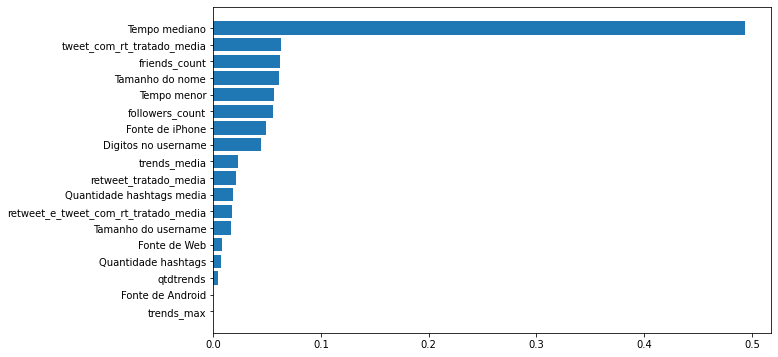

In [ ]:
importances = classifier.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots(figsize =(10, 6))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(x_novo_trend.columns)[indices])

**Resultados**

Os resultados ainda demandam de maior avalia√ß√£o, especialmente com a varia√ß√£o da semente aleat√≥ria para os cortes do conjunto de treinamento e para a aplica√ß√£o dos m√©todos. Ainda nesse sentido, demanda-se ainda da sele√ß√£o de modelos baseada na otimiza√ß√£o dos hiperpar√¢metros dos m√©todos aplicados.

Mesmo com essas demandas, observa-se uma acur√°cia aproximada de 74% para os m√©todos (e aproximadamente 70% ao considerar-se o desbalanceamento da base). Valor considerado bom, dado o complexo cen√°rio tratado. 

Importante ponto a ser destacado que o valor da acur√°cia baseia-se tamb√©m em um ponto de corte da consist√™ncia da classifica√ß√£o, a qual pode variar en 0.0 e 1.0, valores que atrelam-se √† probabilidade da classifica√ß√£o, em que por padr√£o adota-se o corte em 0.5, apesar da aplica√ß√£o pode gerar um intervalo mais restrito, deslocando a m√©dia/mediana das predi√ß√µes. Dito isso e considerando que n√£o deva ser utilizado apenas o corte "bruto" de bot ou n√£o bot, a associa√ß√£o dessa probabilidade permite melhor compreens√£o do "risco" do usu√°rio ser efetivamente um bot, bem como permite um deslocamento do rigor dessa classifica√ß√£o. 

Os trechos a seguir avaliam a acur√°cia considerando a mediana das predi√ß√µes como corte, bem como a compara√ß√£o dos valores preditos nos grupos de usu√°rios previamente (manualmente) classificados como bot ou n√£o, no qual verifica-se uma clara separa√ß√£o dos valores preditos.

In [ ]:
#x_new_trend = SelectKBest(chi2, k=10).fit_transform(x_novo_trend, y)

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x_new_trend, y, test_size=0.3, random_state=1) 

In [ ]:
#classifier = RandomForestClassifier(n_jobs=3, random_state=1, n_estimators=100)
#classifier = classifier.fit(x_train,y_train)
#y_pred = classifier.predict(x_test)
#mean = np.mean(y_pred == y_test)
#balanced = balanced_accuracy_score(y_test, y_pred)
#print ("Mean: " + str(mean) + " | Balanced accuracy: " + str(balanced))
#confusion_matrix(y_test, y_pred)

In [ ]:
#x_new_trend

In [ ]:
#confusion_matrix(y_test, y_pred)

In [ ]:
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1])

In [ ]:
classifier.predict_proba(x_test)

array([[0.82234616, 0.17765384],
       [0.06307788, 0.93692212],
       [0.96424636, 0.03575364],
       [0.18783281, 0.81216719],
       [0.19107317, 0.80892683],
       [0.9434401 , 0.0565599 ],
       [0.55484673, 0.44515327],
       [0.81912638, 0.18087362],
       [0.1072045 , 0.8927955 ],
       [0.41184308, 0.58815692],
       [0.02048731, 0.97951269],
       [0.7882086 , 0.2117914 ],
       [0.12182653, 0.87817347],
       [0.16023543, 0.83976457],
       [0.21667676, 0.78332324],
       [0.13156947, 0.86843053],
       [0.06477248, 0.93522752],
       [0.55086252, 0.44913748],
       [0.0583293 , 0.9416707 ],
       [0.20576939, 0.79423061],
       [0.03236921, 0.96763079],
       [0.0346709 , 0.9653291 ],
       [0.33333473, 0.66666527],
       [0.44441443, 0.55558557],
       [0.50592871, 0.49407129],
       [0.75879899, 0.24120101],
       [0.09265759, 0.90734241],
       [0.84428435, 0.15571565],
       [0.3508184 , 0.6491816 ],
       [0.03358033, 0.96641967],
       [0.

In [ ]:
predicted_proba = classifier.predict_proba(x_test)[0]

In [ ]:
y_test

73     0
551    1
117    0
372    1
216    1
      ..
344    1
40     1
89     0
453    1
605    1
Name: √â Bot?, Length: 251, dtype: int64

In [ ]:
np.median(classifier.predict_proba(x_test)[:,1])

0.7796670548979613

In [ ]:
threshold = 0.6
predicted = (classifier.predict_proba(x_test)[:,1] >= threshold).astype(bool)

In [ ]:
np.mean(predicted == y_test)

0.7609561752988048

In [ ]:
x_test_geral = x_test
dtf = [x_test, x_train]
x_test_geral = pd.concat(dtf)

834


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


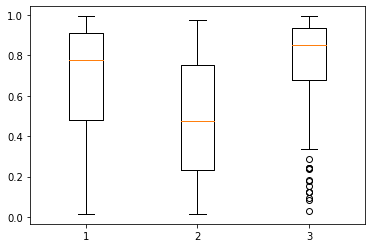

In [ ]:
print(len(x_test_geral))
y_test_temp = y_test
y_test_temp.reset_index(drop=True, inplace=True)
y_test_temp[y_test_temp == 1].index
res_geral = classifier.predict_proba(x_test_geral)[y_test_temp.index,1]
res_sim = classifier.predict_proba(x_test_geral)[y_test_temp[y_test_temp == 1].index,1]
res_nao = classifier.predict_proba(x_test_geral)[y_test_temp[y_test_temp == 0].index,1]

np.median(res_sim)
np.median(res_nao)
bplots = plt.boxplot([res_geral, res_nao, res_sim],  vert = 1, patch_artist = False)

In [ ]:
pd.DataFrame({"N√£o": res_nao}).describe()

N√£o
count  84.000000
mean    0.479382
std     0.284891
min     0.014898
25%     0.232253
50%     0.475195
75%     0.750450
max     0.973344

In [ ]:
pd.DataFrame({"Sim": res_sim}).describe()

Sim
count  167.000000
mean     0.767758
std      0.233861
min      0.030042
25%      0.678627
50%      0.850146
75%      0.938179
max      0.994026

**Compara√ß√£o com as predi√ß√µes do Botometer**

Visando a avaliar a qualidade da classifica√ß√£o dos modelos gerados, os mesmos usu√°rios passaram pela avalia√ß√£o da ferramenta Botometer, j√° bem conhecida e amplamente utilizada (apesar de sua aplica√ß√£o com enfoque nas publica√ß√µes em Ingl√™s).

In [ ]:
#L√™ os dados da aplica√ß√£o do botometer
#Busca os dados dos usu√°rios avaliados
datafile_botometer = "/content/sample_data/handles_inct.csv"
df_botometer = pd.read_csv(datafile_botometer, header = 0)
#Preenche os valores NaN con 0 apenas para avalia√ß√£o geral
df_botometer = df_botometer.fillna(0)
print(len(df_botometer))
df_botometer.head()

1074


Unnamed: 0  Unnamed: 0.1                         tabelaAmostra         p  \
0           0             1         https://twitter.com/@lemathes  0000.csv   
1           1             2  https://twitter.com/@Maurcio98905595  0000.csv   
2           2             3         https://twitter.com/@LunViana  0000.csv   
3           3             4     https://twitter.com/@felipeleixas  0000.csv   
4           4             5  https://twitter.com/@JoseCar41451194  0000.csv   

  √â Bot? Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0    n√£o                                      n√£o se aplica            0   
1    n√£o                                      n√£o se aplica            0   
2    n√£o                                      n√£o se aplica            0   
3    sim                                  Publicar hashtags       Atacar   
4    N√£o                                      n√£o se aplica            0   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   
1                      n√£o                                        n√£o   
2                      n√£o                                        n√£o   
3                      sim                                        sim   
4                      n√£o                                        n√£o   

  Parece s√≥ Retweetar? S√≥ compartilha links? S√≥ faz coment√°rios?  \
0                  n√£o                   n√£o                 n√£o   
1                  n√£o                   n√£o                 n√£o   
2                  n√£o                   n√£o                 n√£o   
3                  n√£o                   n√£o                 n√£o   
4                  n√£o                   n√£o                 n√£o   

  Enaltece muito outros usu√°rios? Faz muito uso de emojis?  \
0                             n√£o                      n√£o   
1                             n√£o                      n√£o   
2                             n√£o                      n√£o   
3                             n√£o                      n√£o   
4                             n√£o                      n√£o   

  Tem muitos posts sem textos? Unnamed: 14           handle  
0                          n√£o           0         lemathes  
1                          n√£o           0  Maurcio98905595  
2                          n√£o           0         LunViana  
3                          n√£o           0     felipeleixas  
4                          n√£o           0  JoseCar41451194

In [ ]:
#Avalia os resultados do botometer
a = len(df_botometer['analise_botometer'])
b = len(df_botometer[(df_botometer['√â Bot?'] == 'n√£o') | (df_botometer['√â Bot?'] == 'N√£o')]['analise_botometer'])
c = len(df_botometer[(df_botometer['√â Bot?'] == 'sim') | (df_botometer['√â Bot?'] == 'Sim')]['analise_botometer'])
print(" " + str(a) + " = " + str(b) + " + " + str(c))
botometer_geral = df_botometer['analise_botometer']
botometer_nao   = df_botometer[(df_botometer['√â Bot?'] == 'n√£o') | (df_botometer['√â Bot?'] == 'N√£o')]['analise_botometer']
botometer_sim   = df_botometer[(df_botometer['√â Bot?'] == 'sim') | (df_botometer['√â Bot?'] == 'Sim')]['analise_botometer']

KeyError: ignored

In [ ]:
plt.figure(figsize =(20, 10)) #(11, 6)
bplots = plt.boxplot([botometer_geral/5, botometer_nao/5, botometer_sim/5, res_geral, res_nao, res_sim],  vert = 1, patch_artist = False)
colors = ['blue', 'green', 'red', 'lightblue', 'lightgreen', 'pink']
c = 0
for i, bplot in enumerate(bplots['boxes']):
    bplot.set(color=colors[c], linewidth=3)
    c += 1
    
colorss = ['blue','blue', 'green', 'green', 'red', 'red', 'lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'pink', 'pink' ]    
c3 = 0
for cap in bplots['caps']:
    cap.set(color=colorss[c3], linewidth=3)
    c3 +=1

plt.title("Boxplot da avalia√ß√£o do Botometer e do novo modelo Pegabot para os dados avaiados no INCT-DD", loc="center", fontsize=18)
plt.xlabel("Agrupados por: (1) Botometer Geral; (2) Botometer apenas considerados n√£o bots; (3) Botometer apenas considerados bots; (4) Novo Pegabot Geral; (5) Novo Pegabot apenas considerados n√£o bots; (6) Novo Pegabot apenas considerados bots")
plt.ylabel("Avalia√ß√£o do Botometer")

plt.show()

NameError: ignored

<Figure size 1440x720 with 0 Axes>

In [ ]:
import scipy
scipy.stats.kruskal(botometer_geral,  botometer_nao,botometer_sim)

In [ ]:
scipy.stats.kruskal(res_geral,  res_nao,res_sim)

<h1> An√°lise de Sentimento</h1>

<h2>Objetivo</h2>

Criar um novo atributo que possa ser utilizado no motor aplicando an√°lise de sentimento para indicar com base no texto do twitte se ele √© agresssivo ou n√£o.

Para esse primeiro teste fazer merge dos dataframes j√° gerados (df_handles, df_users e df_result_text) de forma a obter um novo dataframe que contenha os seguintes atributos: 'Comportamento agressivo?', 'tweet_author', 'tweet_text_y'

In [15]:
!pip install nltk
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
! pip install nltk.examples

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement nltk.examples (from versions: none)
ERROR: No matching distribution found for nltk.examples


In [253]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.test.portuguese_en_fixt import setup_module
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [273]:
df_handles['Comportamento agressivo?'].head()

0    n√£o
1    n√£o
2    n√£o
3    sim
4    n√£o
Name: Comportamento agressivo?, dtype: object

In [274]:
#Sele√ß√£o do texto e com o r√≥tulo √© agressivo ou n√£o
df_result_merge_text = pd.merge(df_handles, df_users, on=['handle'])
df_result_merge_text = pd.merge(df_result_merge,df_result_text, left_on=['handle'], right_on=['tweet_author'])
print(len(df_result_merge_text))
df_result_merge_text.head(1)

834


Unnamed: 0_x  Unnamed: 0.1                  tabelaAmostra         p √â Bot?  \
0             0             1  https://twitter.com/@lemathes  0000.csv    n√£o   

  Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria? Fun√ß√£o #2  \
0                                      n√£o se aplica          NaN   

  Comportamento agressivo? Comportamento repetitivo com # ou men√ß√µes?  \
0                      n√£o                                        n√£o   

  Parece s√≥ Retweetar?  ... lang           location            name  \
0                  n√£o  ...  0.0  Brasil, S√£o Paulo  Leandro Mathes   

                                       profile_image  twitter_id  \
0  http://pbs.twimg.com/profile_images/1141547105...  52253248.0   

  twitter_is_protected verified  withheld_in_countries  tweet_author  \
0                  0.0      0.0                     []      lemathes   

                                          tweet_text  
0  @LucianoHangBr J√° demorou muito!, RT @LucianoH...  

[1 rows x 36 columns]

In [275]:
df_result_merge_text['Comportamento agressivo?'] = df_result_merge_text['Comportamento agressivo?'].str.lower()
df_result_merge_text['tweet_text'] = df_result_merge_text['tweet_text'].str.lower()

In [276]:
df_result_merge_text_analise=df_result_merge_text[['Comportamento agressivo?', 'tweet_author', 'tweet_text']]
print("\nDimens√µes:\n")
print("Shape:", df_result_merge_text_analise.shape)
print("\nQuantidade de dados faltantes:\n")
print(df_result_merge_text_analise.isnull().sum())


Dimens√µes:

Shape: (834, 3)

Quantidade de dados faltantes:

Comportamento agressivo?    0
tweet_author                0
tweet_text                  0
dtype: int64


In [277]:
df_result_merge_text_analise['Tamanho'] = df_result_merge_text_analise['tweet_text'].apply(len)
print("Tamanho dos coment√°rios:\n")
df_result_merge_text_analise.head()

Tamanho dos coment√°rios:



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Comportamento agressivo?     tweet_author  \
0                      n√£o         lemathes   
1                      n√£o  Maurcio98905595   
2                      n√£o         LunViana   
3                      sim     felipeleixas   
4                      n√£o  JoseCar41451194   

                                          tweet_text  Tamanho  
0  @lucianohangbr j√° demorou muito!, rt @lucianoh...    10004  
1  hosp√≠cio....louca. https://t.co/34bby21hrq, . ...     7015  
2  rt @jairbolsonaro: - rio de janeiro / rj: o @g...    11420  
3  @rachelsherazade vc chama isso de jornalismo? ...     2846  
4  rt @brazilfight: jana√≠na paschoal\n"jamais um ...    11465

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribui√ß√£o do tamanho do texto')

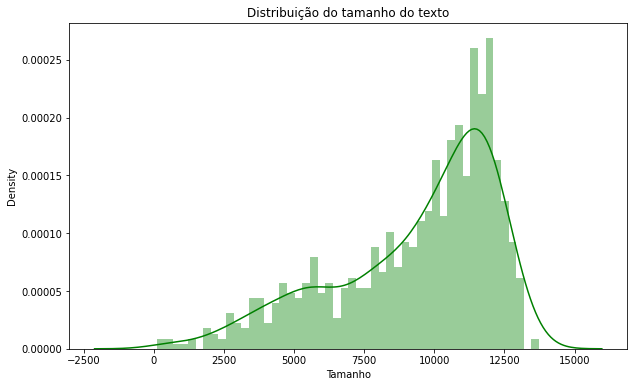

In [278]:
df_dist_grafico = plt.figure(figsize=(10,6))
sns.distplot(df_result_merge_text_analise['Tamanho'], kde=True, bins=50, color="green")
plt.title('Distribui√ß√£o do tamanho do texto')

In [279]:
#total de sim e n√£o
total = df_result_merge_text_analise['Comportamento agressivo?'].count()
total_sim = (df_result_merge_text_analise['Comportamento agressivo?']=='sim').sum()
total_nao = (df_result_merge_text_analise['Comportamento agressivo?']=='n√£o').sum()
print("Total:", total)
print("Total de sim:", total_sim)
print("Total de n√£o:", total_nao)

Total: 834
Total de sim: 98
Total de n√£o: 735


<h2> Problema 1</h2>

Nos dados dispon√≠veis existem um desbalanceamento das classes Comportamento agressivo? (sim ou n√£o), onde a classe 'n√£o' √© a majorit√≥ria e a classe 'sim' a minot√≥ria. Isso induzir√° o algoritmo de classifica√ß√£o a tender mais para a classe majorit√°ria prejudicando na acur√°cia do modolo.

Existem m√©todos para tratamento de classes desbanlanceadas como o **Undersampling** e o **Oversampling**.

*  **Undersampling**: √© uma t√©cnica que consiste em manter todos os dados da classe com menor frequ√™ncia (minorit√°ria) e diminuir a quantidade dos que est√£o na classe de maior frequ√™ncia (majorit√°ria), fazendo com que as observa√ß√µes no conjunto possuam dados com a vari√°vel alvo equilibrada. Uma das t√©cnicas mais utilizadas √© o Near Miss que diminui aleatoriamente a quantidade de valores da classe majorit√°ria. Vale destacar que o Near Miss utiliza a menor dist√¢ncia m√©dia dos K-vizinhos mais pr√≥ximos, ou seja, seleciona os valores baseando-se no m√©todo KNN (K-nearest neighbors) para reduzir a perda de informa√ß√£o.
*   **Oversampling**:  √© uma t√©cnica que consiste em aumentar a quantidade de registros da classe com menor frequ√™ncia at√© que a base de dados possua uma quantidade equilibrada entre as classes da vari√°vel alvo. Para evitar que existam muitos dados id√™nticos, pode ser utilizada a t√©cnica SMOTE (Synthetic Minority Over-sampling Technique), que consiste em sintetizar novas informa√ß√µes com base nas j√° existentes. Esses dados ‚Äúsint√©ticos‚Äù s√£o relativamente pr√≥ximos aos dados reais, mas n√£o s√£o id√™nticos. 

**Refer√™ncias:**
https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados
https://acervolima.com/ml-manipulacao-de-dados-desequilibrados-com-smote-e-algoritmo-de-quase-perda-em-python/

In [280]:
texto = df_result_merge_text_analise[['Comportamento agressivo?', 'tweet_author', 'tweet_text']]
texto['Tamanho'] = texto['tweet_text'].apply(len)

In [281]:
texto['tweet_text'] = texto['tweet_text'].str.replace("rt", "")
texto['tweet_text'] = texto['tweet_text'].str.replace("https", "")
#texto['tweet_text'] = texto['tweet_text'].str.replace("@", "")
#texto['tweet_text'] = texto['tweet_text'].str.replace("#", "")
texto['tweet_text']

0      @lucianohangbr j√° demorou muito!,  @lucianohan...
1      hosp√≠cio....louca. ://t.co/34bby21hrq, . ://t....
2       @jairbolsonaro: - rio de janeiro / rj: o @gov...
3      @rachelsherazade vc chama isso de jornalismo? ...
4       @brazilfight: jana√≠na paschoal\n"jamais um br...
                             ...                        
829     @claudeluca_: algu√©m tem not√≠cia de quando v√£...
830    @dindorio te seguindo, patriota !!! sdv ????\n...
831    @beta_jesse üëèüëèüëèüëè por isso #lavajatoorgulhodobr...
832     @drbots2: ---\njusti√ßa condena influenciador ...
833    @camelojubeni @konigmachado @marcos_28_11_66 @...
Name: tweet_text, Length: 834, dtype: object

In [282]:
#stopWord = stopwords.words("portuguese")
stopWords = nltk.corpus.stopwords.words('portuguese')

In [284]:
def remove_puntuacao_stopwords(texto):

    remove_puntacao = [word for word in texto.lower() if word not in string.punctuation]
    remove_puntacao = ''.join(remove_puntacao)
    return [word for word in remove_puntacao.split() if word not in stopWord]

In [285]:
texto_preprocessado = texto.copy()
texto_preprocessado['tweet_text'] = texto['tweet_text'].apply(remove_puntuacao_stopwords)
texto_preprocessado['Tamanho'] = texto_preprocessado['tweet_text'].apply(len)
print("Tamanho dos coment√°rios ap√≥s aplica√ß√£o do stopword:\n")
texto_preprocessado.head()

Tamanho dos coment√°rios ap√≥s aplica√ß√£o do stopword:



Comportamento agressivo?     tweet_author  \
0                      n√£o         lemathes   
1                      n√£o  Maurcio98905595   
2                      n√£o         LunViana   
3                      sim     felipeleixas   
4                      n√£o  JoseCar41451194   

                                          tweet_text  Tamanho  
0  [lucianohangbr, demorou, lucianohangbr, vida, ...      871  
1  [hosp√≠ciolouca, tco34bby21hrq, tcol9zmyju15t, ...      527  
2  [jairbolsonaro, rio, janeiro, rj, govbr, meio,...     1026  
3  [rachelsherazade, vc, chama, jornalismo, v√≠deo...      252  
4  [brazilfight, jana√≠na, paschoal, jamais, brasi...     1036

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribui√ß√£o do tamanho do texto ap√≥s aplica√ß√£o de STOPWORD')

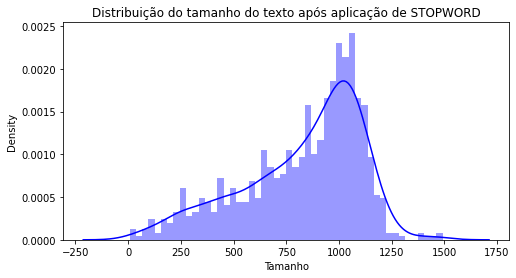

In [286]:
df_dist_grafico_processado = plt.figure(figsize=(8,4))
sns.distplot(texto_preprocessado['Tamanho'], kde=True, bins=50, color="blue")
plt.title('Distribui√ß√£o do tamanho do texto ap√≥s aplica√ß√£o de STOPWORD')

In [287]:
def grafico_frequencia(data):
    plt.figure(figsize=(10,5))
    FreqDist(np.concatenate(data.tweet_text.reset_index(drop=True))).plot(25, cumulative=False, color="green")

Gr√°fico de frequ√™ncia de Comportamento agressivo = sim:



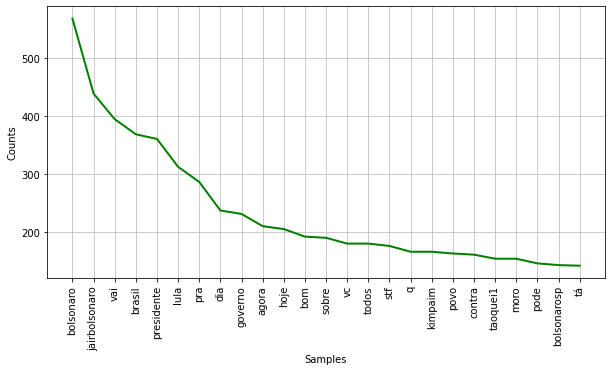

In [288]:
print("Gr√°fico de frequ√™ncia de Comportamento agressivo = sim:\n")
grafico_frequencia(texto_preprocessado[texto_preprocessado['Comportamento agressivo?']=='sim'])

Gr√°fico de frequ√™ncia de Comportamento agressivo = n√£o:



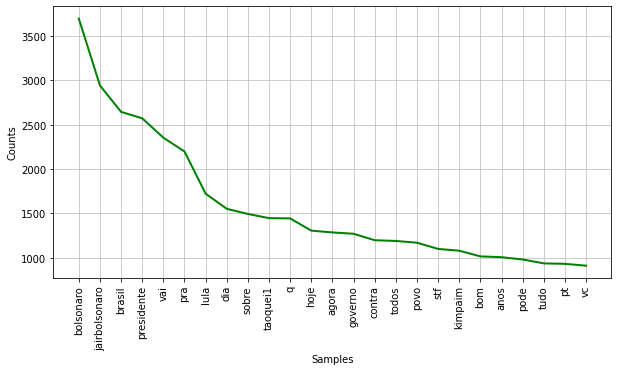

In [289]:
print("Gr√°fico de frequ√™ncia de Comportamento agressivo = n√£o:\n")
grafico_frequencia(texto_preprocessado[texto_preprocessado['Comportamento agressivo?']=='n√£o'])

In [290]:
def nuvem_palavras(Agressivo):
    Agressivotexto = ' '.join(texto[texto['Comportamento agressivo?']==Agressivo]['tweet_text'])
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        colormap="hsv",
        stopwords = STOPWORDS).generate(str(Agressivotexto))

    fig = plt.figure(
        figsize = (10, 5),
        facecolor = 'k',
        edgecolor = 'k',)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

Nuvem de palavras para agressivo sim:



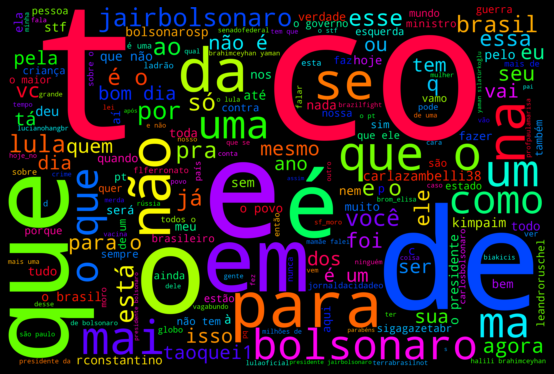

In [291]:
print("Nuvem de palavras para agressivo sim:\n")
nuvem_palavras('sim')

Nuvem de palavras para agressivo n√£o:



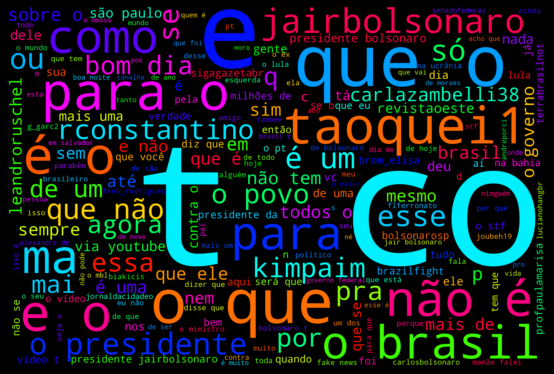

In [292]:
print("Nuvem de palavras para agressivo n√£o:\n")
nuvem_palavras('n√£o')

In [293]:
#Padroniza a sa√≠da da classifica√ß√£o do INCT-DD para bot e monta o conjunto Y
texto_preprocessado

Comportamento agressivo?     tweet_author  \
0                        n√£o         lemathes   
1                        n√£o  Maurcio98905595   
2                        n√£o         LunViana   
3                        sim     felipeleixas   
4                        n√£o  JoseCar41451194   
..                       ...              ...   
829                      n√£o  CesarNi85939384   
830                      n√£o  PauloRo49195361   
831                      n√£o   Marina92011959   
832                      n√£o  Marcos_28_11_66   
833                      n√£o  FATIMAC75843178   

                                            tweet_text  Tamanho  
0    [lucianohangbr, demorou, lucianohangbr, vida, ...      871  
1    [hosp√≠ciolouca, tco34bby21hrq, tcol9zmyju15t, ...      527  
2    [jairbolsonaro, rio, janeiro, rj, govbr, meio,...     1026  
3    [rachelsherazade, vc, chama, jornalismo, v√≠deo...      252  
4    [brazilfight, jana√≠na, paschoal, jamais, brasi...     1036  
..                                                 ...      ...  
829  [claudeluca, algu√©m, not√≠cia, v√£o, cassar, man...     1026  
830  [dindorio, seguindo, patriota, sdv, fechadocom...      680  
831  [betajesse, üëèüëèüëèüëè, lavajatoorgulhodobrasil, tas...      669  
832  [drbots2, justi√ßa, condena, influenciador, ass...     1057  
833  [camelojubeni, konigmachado, marcos281166, kon...      933  

[834 rows x 4 columns]

<h2> Problema 2</h2>

Apesar de ter retirado as stopwords, os textos do Twitter cont√© muitos rt, https, emojis que precisam ser removidos de forma a deixa apenas texto √∫til. Isso pode ser visualizado nos gr√°ficos de frequ√™ncia e n√∫vens de palavras que foram gerados.

√â necess√°rio pensar numa forma de remover isso do texto, seja por express√£o regular ou por meio de c√≥digo em Python

In [294]:
x = texto_preprocessado['tweet_text']
x.head()

0    [lucianohangbr, demorou, lucianohangbr, vida, ...
1    [hosp√≠ciolouca, tco34bby21hrq, tcol9zmyju15t, ...
2    [jairbolsonaro, rio, janeiro, rj, govbr, meio,...
3    [rachelsherazade, vc, chama, jornalismo, v√≠deo...
4    [brazilfight, jana√≠na, paschoal, jamais, brasi...
Name: tweet_text, dtype: object

In [295]:
y = texto_preprocessado['Comportamento agressivo?'].apply(lambda x: 1 if (x == 'sim') else 0)
y.reset_index(drop=True, inplace=True)
y.head()

0    0
1    0
2    0
3    1
4    0
Name: Comportamento agressivo?, dtype: int64

In [297]:
vetorizar = CountVectorizer(analyzer=lambda x: x).fit(x)
x = vetorizar.transform(x)

In [298]:
print("Dimens√µes da matrix esparsa: ", x.shape)

Dimens√µes da matrix esparsa:  (834, 102549)


In [299]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [300]:
smt = SMOTE(k_neighbors=5, random_state=42)
x_train, y_train = smt.fit_resample(x_train, y_train)
#x_train, y_train = smt.fit_resample(x_train, y_train)
np.bincount(y_train)

array([524, 524])

In [301]:
mnb = MultinomialNB()

mnb.fit(x_train,y_train)
predicao_mnb = mnb.predict(x_test)

In [302]:
print("Matriz de Confus√£o - Multinomial Naive Bayes:\n")
print(confusion_matrix(y_test,predicao_mnb))
print("\nRelat√≥rio de Classifica√ß√£o:",classification_report(y_test,predicao_mnb))

Matriz de Confus√£o - Multinomial Naive Bayes:

[[200  12]
 [ 37   2]]

Relat√≥rio de Classifica√ß√£o:               precision    recall  f1-score   support

           0       0.84      0.94      0.89       212
           1       0.14      0.05      0.08        39

    accuracy                           0.80       251
   macro avg       0.49      0.50      0.48       251
weighted avg       0.73      0.80      0.76       251



In [258]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confus√£o',
                          cmap=plt.cm.Blues):
    """
    Esta fun√ß√£o imprime e plota a matriz de confus√£o.
    A normaliza√ß√£o pode ser aplicada definindo `normalize = True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confus√£o normalizada\n")
    else:
        print('Matriz de confus√£o sem normaliza√ß√£o\n')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Matriz de confus√£o sem normaliza√ß√£o

[[200  12]
 [ 37   2]]


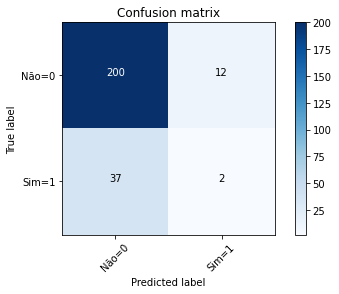

In [259]:
# Calculando a confusion matrix
matriz_confusao = confusion_matrix(y_test, predicao_mnb, labels=[0,1])
np.set_printoptions(precision=2)
# Imprimindo a matriz de confus√£o sem normaliza√ß√£o
plt.figure()
plot_confusion_matrix(matriz_confusao, classes=['N√£o=0','Sim=1'],normalize= False,  title='Confusion matrix')

<h2> An√°lise do Resultado</h2>

Pela matriz de confus√£o √© poss√≠vel observar que o modelo foi muito assertivo em classificar a classe "agressivo = n√£o", justamente por ela ser a classe majorit√°ria acertando 198 e errando apenas 14, e foi muito ruim em classificar a classe "agressivo = sim", acertando apenas 1.



<h1>Classifica√ß√£o do tipo de bot</h1>

<h2>Objetivo</h2>

Criar um novo atributo que indique a classifica√ß√£o do tipo de bot tomando com esse r√≥tulo j√° existente no dataframe df_handles.

Para esse classificador √© necess√°rio analisar os demais atributos dos outros dataframes para um levantamento dos que sejam mais √∫teis para ajudar na modelagem desse classificador.

In [57]:
#Lista as fun√ß√µes atribu√≠das ao bots
funcao_bot = df_handles['Se voc√™ fosse atribuir uma fun√ß√£o ao bot, qual seria?'].unique()
funcao_bot

array(['n√£o se aplica', 'Publicar hashtags', 'Compartilhar links',
       'publicar hashtags', 'Retweetar', 'compartilhar links', 'Postar',
       'Responder', 'compartilhar links ', 'Comentar', 'Atacar',
       'retweetar', 'atacar', 'Publicar imagens ou v√≠deos',
       'Mostrar Tweets apagados de atores pol√≠ticos'], dtype=object)

<h1>Classifiaca√ß√£o de emoji</h1>

<h2>Objetivo</h2>

Classificar os emoji de acordo com o signifcado dos mesmos


O link abaixo lista os principais emoji
https://gist.github.com/rxaviers/7360908

A figura abaixo mostra a quantidade dos emojis mais usados agrupados por categorias (Amor, Felicidade, etc)

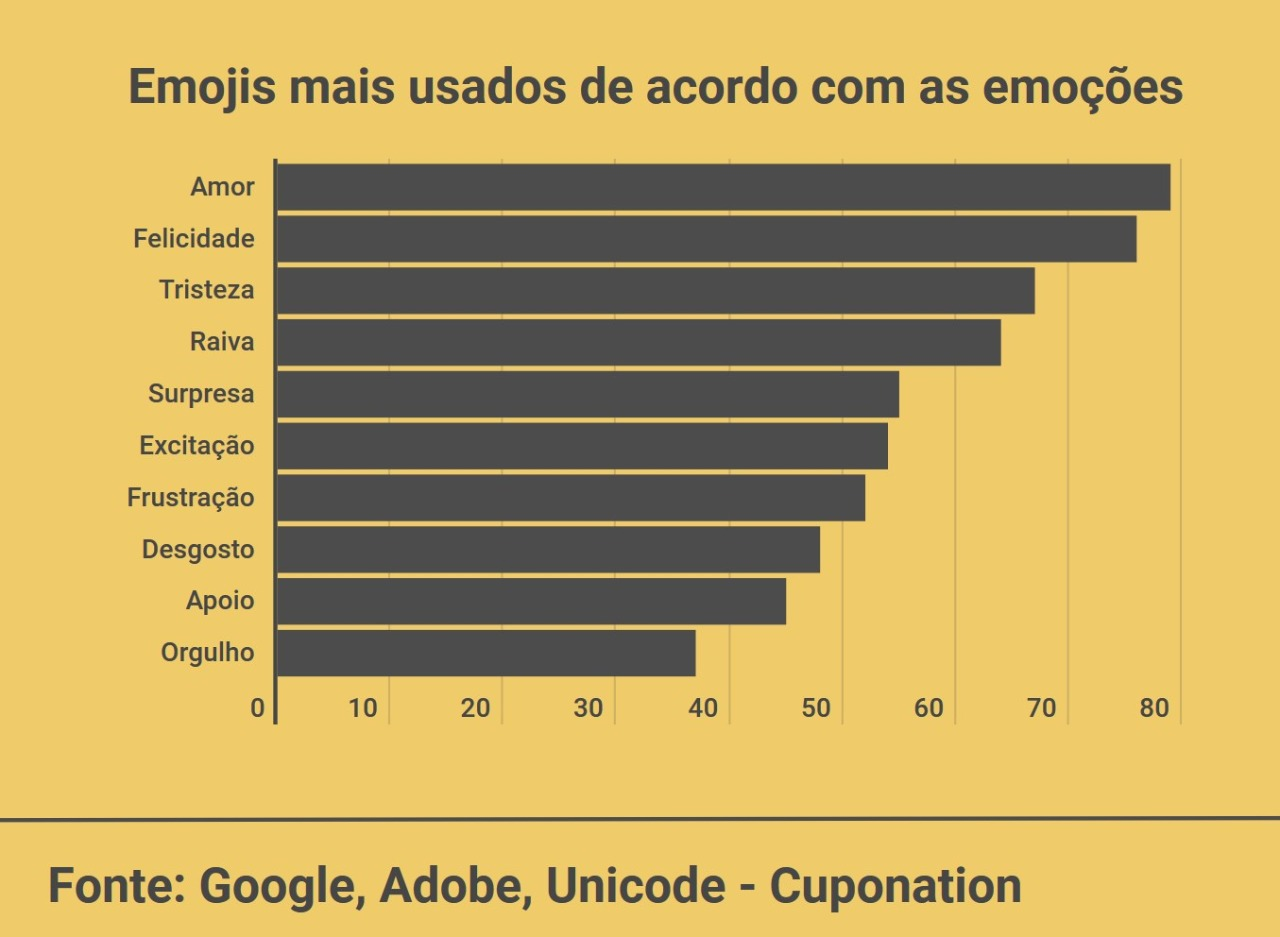